# Variational data generative model for intrusion detection

#### The objective of a Network Intrusion Detection System (NIDS) is to automate the detection of policy and security violations and malicious activities against a host in a network. Critical to any detection system is the ability to access balanced and diversified data to train the system. Intrusion data rarely have these characteristics, as the network traffic samples are strongly biased to the normal type of traffic, being difficult to access traffic associated to anomalous intrusion events. Therefore, it is important to be able to synthesize intrusion data with a structure similar to the original one. In this way, we avoid investing significant resources in tasks such as obtaining additional intrusion data or manually simulating attacks. In this work we provide a method to generate synthetic data of similar probabilistic structure to real intrusion detection training data, having both continuous and categorical features and being strongly unbalanced to some of their associated classes. We generate the data conditioned to the class (label) to which the data should belong. That is, from a particular set of labels we generate training samples associated to that set of labels, mirroring the probabilistic structure of the original data that comes from those labels. We use a generative model based on Variational Autoencoder (VAE) concepts but using the intrusion class labels as input, instead of the original data itself. This modification provides an advantage, as we can readily generate new data using only the labels, without having to rely on training samples as canonical representatives for each label, what makes the generation process more reliable, less complex and much faster. We show that the generated data have similar probabilistic structure to the original data, and that the new synthesized data can be used to improve classification results from common machine learning classifiers.

# 1. Prepare dataset
#### Load NSL-KDD dataset to perform training of the model and latter to assess its performance

In [1]:

# set working directory
import os
os.chdir("W:/UVA/InvestigacionUVA/Informe proyecto 2017/Codigo_papers/vae")

####################################################
# Load variables from previous session
####################################################
import dill
#dill.load_session('tf_NSL_KDD_Load.pkl')
load_from_pkl = True
if load_from_pkl:
    dill.load_session('tf_NSL_KDD20_Load_withWs.pkl')
####################################################

In [2]:
import sklearn
sklearn.__version__

'0.18.1'

In [3]:
import lib
import sklearn
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
import pandas.core.algorithms as algos
from pandas import Series
from sklearn.preprocessing import OneHotEncoder



## 1.1 Create Training and Test datasets
#### Next we need to prepare the test and train data with one-hot encoding. We need to scale also the training data as NN is sensitive to data scaling

In [4]:
if not load_from_pkl:
    # create Y, matrix 
    YTrain = dataTrain['class']
    YTest = dataTest['class']


    # create X, matrix 
    XTest = dataTest.drop(['class','difficulty'], axis = 1)
    XTrain = dataTrain.drop(['class','difficulty'], axis = 1)
    lenXTrain = len(XTrain)
    lenXTest = len(XTest)

    # extract continous features
    XTrainContinous = dataTrain.drop(['class','difficulty','protocol_type', 'service','flag'], axis = 1)
    XTestContinous = dataTest.drop(['class','difficulty','protocol_type', 'service','flag'], axis = 1)

    # Eliminate columns which are mainly zeros
    t = XTrainContinous.apply(lambda x: sum(x != 0)) 
    minNumZeros = 100
    indexToErase = t[t<100].index
    XTrainContinous = XTrainContinous.drop(indexToErase, axis = 1)
    XTestContinous = XTestContinous.drop(indexToErase, axis = 1)

    # convert columns with continous data to categorical data, using a quantile over the values of each column.
    #XTrainContinousAsDis = XTrainContinous.apply(lambda x: pd.qcut(x, 20, labels=False))
    #XTestContinousAsDis = XTestContinous.apply(lambda x: pd.qcut(x, 20, labels=False))
    nBins = 40  # number of bins when doing the quantiles
    XTrainContinousAsDis = XTrainContinous.apply(lambda x: lib.helpFun2 (x, nBins)).astype(str)
    XTestContinousAsDis = XTestContinous.apply(lambda x: lib.helpFun2 (x, nBins)).astype(str)

    # extract discrete features
    XTrainDiscrete = dataTrain.loc[:,['protocol_type', 'service','flag']]
    XTestDiscrete = dataTest.loc[:,['protocol_type', 'service','flag']]

    # normalize the continous features

    # apply log(x+1) transform to features with great range
    tXTest = XTestContinous[['duration', 'src_bytes','dst_bytes','num_compromised',
    'num_root', 'count', 'srv_count', 'dst_host_count', 'dst_host_srv_count']]
    tXTrain = XTrainContinous[['duration', 'src_bytes','dst_bytes','num_compromised',
    'num_root', 'count', 'srv_count', 'dst_host_count', 'dst_host_srv_count']]

    XTestContinous[['duration', 'src_bytes','dst_bytes','num_compromised',
                    'num_root', 'count', 'srv_count', 'dst_host_count', 
                    'dst_host_srv_count']] = tXTest.apply(lambda x: np.log(x+1), 0)
    XTrainContinous[['duration', 'src_bytes','dst_bytes','num_compromised',
                     'num_root', 'count', 'srv_count', 'dst_host_count',
                     'dst_host_srv_count']] = tXTrain.apply(lambda x: np.log(x+1), 0)
    # and then apply an additional min-max or standard scaler to all the continous features
    scaler = MinMaxScaler()
    #scaler = StandardScaler()
    XTrainContinous = pd.DataFrame(scaler.fit_transform(XTrainContinous), columns=XTrainContinous.columns)
    XTestContinous = pd.DataFrame(scaler.fit_transform(XTestContinous), columns=XTestContinous.columns)


    # get back the full training data sets
    #XTrainAll =pd.concat([XTrainContinousAsDis,XTrainDiscrete], axis=1)
    #XTestAll =pd.concat([XTestContinousAsDis,XTestDiscrete], axis=1)
    XTrainAll =pd.concat([XTrainContinous,XTrainDiscrete], axis=1)
    XTestAll =pd.concat([XTestContinous,XTestDiscrete], axis=1)

    # one-hot encode the categorical features
    XAll = XTrainAll.append(XTestAll, ignore_index = True)
    #col_names = list(XAll.columns.values)
    col_names = ['protocol_type', 'service','flag']
    XAll, _, _= lib.one_hot_dataframe(XAll, col_names, replace=True)

    # extract XTrain and XTest
    XTrain = XAll.ix[:lenXTrain-1]
    XTest = XAll.ix[lenXTrain:]


    #convert to matrix
    XTrainM = XTrain.as_matrix()
    XTestM = XTest.as_matrix()

    # one hot encode Y and convert to matrix
    YTrainM = YTrain.as_matrix()
    YTestM = YTest.as_matrix()

    # for the VAE
    XTrainContinousM = XTrainContinous.as_matrix()
    XTestContinousM = XTestContinous.as_matrix()
    XAllDiscrete = XTrainDiscrete.append(XTestDiscrete, ignore_index = True)
    XAllDiscrete, _, _= lib.one_hot_dataframe(XAllDiscrete, col_names, replace=True)
    XAllDiscrete_flg = XAllDiscrete.ix[:,:11]
    XAllDiscrete_prot = XAllDiscrete.ix[:,11:14]
    XAllDiscrete_srv = XAllDiscrete.ix[:,14:]
    XTrainDiscreteM = XAllDiscrete.ix[:lenXTrain-1].as_matrix()
    XTestDiscreteM = XAllDiscrete.ix[lenXTrain:].as_matrix()
    XTrainDiscreteflgM = XAllDiscrete_flg.ix[:lenXTrain-1].as_matrix()
    XTestDiscreteflgM = XAllDiscrete_flg.ix[lenXTrain:].as_matrix()
    XTrainDiscreteprotM = XAllDiscrete_prot.ix[:lenXTrain-1].as_matrix()
    XTestDiscreteprotM = XAllDiscrete_prot.ix[lenXTrain:].as_matrix()
    XTrainDiscretesrvM = XAllDiscrete_srv.ix[:lenXTrain-1].as_matrix()
    XTestDiscretsrveM = XAllDiscrete_srv.ix[lenXTrain:].as_matrix()

    num_features = XTrainM.shape[1]

    YTestAN = YTest.apply(lambda x: 'normal' if x == 'normal' else 'anomaly')
    YTestANM = YTestAN.as_matrix()
    YTrainAN = YTrain.apply(lambda x: 'normal' if x == 'normal' else 'anomaly')
    YTrainANM = YTrainAN.as_matrix()
    YTestAN5 =YTest.apply(lambda x: 'NORMAL' if 'normal' in x else LabelToGroup[x])
    YTestAN5M = YTestAN5.as_matrix()
    YTrainAN5 = YTrain.apply(lambda x: 'NORMAL' if 'normal' in x else LabelToGroup[x])
    YTrainAN5M = YTrainAN5.as_matrix()

    # 23 labels
    lb = LabelBinarizer()
    lb.fit(YTrainM)
    #one-hot-encoded
    YTrainMOhe = lb.transform(YTrainM)
    YTestMOhe = lb.transform(YTestM) # this transformation changes YTest, as YTest has labels not present in YTrain

    # 5 labels
    lb5 = LabelBinarizer()
    lb5.fit(YTrainAN5M)
    #one-hot-encoded
    YTrainAN5MOhe = lb5.transform(YTrainAN5M)
    YTestAN5MOhe = lb5.transform(YTestAN5M) # this transformation changes YTest


    # 2 labels
    #one-hot-encoded
    YTrainANMOhe = np.array([[1,0] if x== 'normal' else [0,1] for x in YTrainANM])
    YTestANMOhe = np.array([[1,0] if x== 'normal' else [0,1] for x in YTestANM])



In [5]:
XTrain.shape

(125973, 116)

## 1.2 Additional data preparation
### Additional data preparation needed to create additional features using the Non-negative Matrix Factorization algorithm. These features are not used in this project.

In [6]:
if not load_from_pkl:
    from sklearn.decomposition import NMF

    ## NMF
    # generate the W and H matrices for 23, 5 and components, and for Training and Testing

    nmf23 = NMF(n_components=23, init='nndsvdar', solver='cd', tol=0.0001, 
                max_iter=200, random_state=0, alpha=0.0, l1_ratio=0.0, 
                verbose=0, shuffle=False, nls_max_iter=2000)
    nmf23.fit(XTrainM) 
    W23Train = nmf23.transform(XTrainM)
    W23Test = nmf23.transform(XTestM)
    H23 =nmf23.components_


    nmf5 = NMF(n_components=5, init='nndsvdar', solver='cd', tol=0.0001, 
                max_iter=200, random_state=0, alpha=0.0, l1_ratio=0.0, 
                verbose=0, shuffle=False, nls_max_iter=2000)
    nmf5.fit(XTrainM) 
    W5Train = nmf5.transform(XTrainM)
    W5Test = nmf5.transform(XTestM)
    H5 =nmf5.components_


    nmf2 = NMF(n_components=2, init='nndsvdar', solver='cd', tol=0.0001, 
                max_iter=200, random_state=0, alpha=0.0, l1_ratio=0.0, 
                verbose=0, shuffle=False, nls_max_iter=2000)
    nmf2.fit(XTrainM) 
    W2Train = nmf2.transform(XTrainM)
    W2Test = nmf2.transform(XTestM)
    H2 =nmf2.components_

    nmf50 = NMF(n_components=50, init='nndsvdar', solver='cd', tol=0.0001, 
                max_iter=200, random_state=0, alpha=0.0, l1_ratio=0.0, 
                verbose=0, shuffle=False, nls_max_iter=2000)
    nmf50.fit(XTrainM) 
    W50Train = nmf50.transform(XTrainM)
    W50Test = nmf50.transform(XTestM)
    H50 =nmf50.components_

    from timeit import default_timer as timer
    start = timer()

    nmf75 = NMF(n_components=75, init='nndsvdar', solver='cd', tol=0.0001, 
                max_iter=200, random_state=0, alpha=0.0, l1_ratio=0.0, 
                verbose=0, shuffle=False, nls_max_iter=2000)
    nmf75.fit(XTrainM) 
    W75Train = nmf75.transform(XTrainM)
    W75Test = nmf75.transform(XTestM)
    H75 =nmf75.components_

    end = timer()
    print ("Time elapsed sec: {0}".format(end-start))

    from timeit import default_timer as timer
    start = timer()

    nmf100 = NMF(n_components=100, init='nndsvdar', solver='cd', tol=0.0001, 
                max_iter=200, random_state=0, alpha=0.0, l1_ratio=0.0, 
                verbose=0, shuffle=False, nls_max_iter=2000)
    nmf100.fit(XTrainM) 
    W100Train = nmf100.transform(XTrainM)
    W100Test = nmf100.transform(XTestM)
    H100 =nmf100.components_

    end = timer()
    print ("Time elapsed: {0}".format(end-start))

    # create W matrices with all componets concatenated
    WAllTrain = np.concatenate((W23Train,W5Train,W2Train), axis=1)
    WAllTest = np.concatenate((W23Test,W5Test,W2Test), axis=1)

    # create new training and testing matrices with the original data plus all components coming from W for 23, 5 and 2 components
    XTrainExten = np.concatenate((XTrainM, WAllTrain), axis=1)
    XTestExten = np.concatenate((XTestM, WAllTest), axis=1)

    # create new training and testing matrices with the original data plus the compoenent coming from W23
    XTrainW23 = np.concatenate((XTrainM, W23Train), axis=1)
    XTestW23 = np.concatenate((XTestM, W23Test), axis=1)

    # create new training and testing matrices with the original data plus the compoenent coming from W23
    XTrainW5 = np.concatenate((XTrainM, W5Train), axis=1)
    XTestW5 = np.concatenate((XTestM, W5Test), axis=1)

    # create new training and testing matrices with the original data plus the compoenent coming from W23
    XTrainW2 = np.concatenate((XTrainM, W2Train), axis=1)
    XTestW2 = np.concatenate((XTestM, W2Test), axis=1)

### Dasets sizes

In [7]:
print(XTrainM.shape,YTrainMOhe.shape, XTestM.shape, YTestMOhe.shape, YTestM.shape)

(125973, 116) (125973, 23) (22544, 116) (22544, 23) (22544,)


## 1.3 Support functions
### Additional functions. These functions are support functions that will be used latter.

In [8]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

def accuracy(predictions, labels):
  return (np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))/ predictions.shape[0])

# given probability predictions return the one-hot encoded associated labels
def labelOHEncodedFromPrediction(predictions):
  return ((predictions == np.reshape(np.max(predictions, 1),(len(predictions),-1)))*1)

#transform back labels (one-hot encoded) to strings for the case of labels with 23 values
def invTransLabels(labels):
    return(lb.inverse_transform(labels))

#transform back labels (one-hot encoded) to strings for the case of labels with 5 values
def invTransLabels5labels(labels):
    return(lb5.inverse_transform(labels))

#transform back labels (one-hot encoded) to strings for the case of labels with 2 values
def invTransLabels2labels(labels):
    return(np.array([ 'normal' if (x== [1,0]).all() else 'anomaly' for x in labels]))

def tf_rmse(x, y):
  return (tf.sqrt(tf.reduce_mean(tf.reduce_sum(tf.square(tf.sub(x,y)),1))))


def rmse(x, y):
  return np.sqrt(np.mean((x-y)**2))

# 2. Model. Model C of the paper

## 2.1 Functions to create training batchs
#### This function creates a new training dataset each time it is called

In [10]:
import time
import os
import math
from sklearn.model_selection import StratifiedKFold

class BatchTrainGen(object):

    def __init__(self, X, batch_size =100):
        self.X = X
        self.batch_size = batch_size
        
    def gen_offsets(self, ini = 0):
        self.batch_num = int(self.X.shape[0] / self.batch_size)
        self.indices = np.roll(np.arange(self.X.shape[0]),-ini)
        
    def gen_offsets_random(self, ini = 0):
        self.batch_num = int(self.X.shape[0] / self.batch_size)
        self.indices = np.random.permutation(self.X.shape[0])

    def batch_num(self):
        return self.batch_num
    
    def next_batch(self):
        fold = self.indices[:self.batch_size]
        x_batch = self.X[fold,:]
        self.indices = np.roll(self.indices,-self.batch_size)
        return (x_batch, fold)


## 2.2 Create Keras and tensorflow sessions

In [11]:
import tensorflow as tf
from keras import backend as K
from keras.layers import Dense
from keras.layers import Dropout
import keras

# attach keras and tensorflow
sess = tf.InteractiveSession()
K.set_session(sess)

tf.set_random_seed(1)

Using TensorFlow backend.


## 2.3 Functions to create different models

In [12]:

def config_nn_1(num_hidden_vars, f_activation = 'relu'):
    x_ini = tf.placeholder(tf.float32, [None, input_dim], name='x_ini')
    labels = tf.placeholder(tf.float32, [None, labels_dim], name='y')
    
    k= 1  # dropout probability
    # Keras layers can be called on TensorFlow tensors:
    #LR = keras.layers.advanced_activations.LeakyReLU(alpha=0)
    
    # encoder
    xe = Dense(500, activation = f_activation)(x_ini)  # fully-connected layer 
    xe = Dropout(k)(xe)
    xe = Dense(500, activation = f_activation)(xe)
    xe = Dropout(k)(xe)
    
    #posterior distributions
    z_mu = Dense(num_hidden_vars, activation = 'linear')(xe)
    z_log_sigma = Dense(num_hidden_vars, activation = 'linear')(xe)
    # Sample epsilon
    epsilon = tf.random_normal(tf.shape(z_log_sigma), name='epsilon')
    # Sample from posterior
    z = z_mu + tf.exp(z_log_sigma) * epsilon
    
    # decoder
    xd = Dense(300, activation = f_activation)(z)  # fully-connected layer 
    xd1 = Dropout(k)(xd)
    labels_ext = tf.tile(labels, [1,40]) # repeat the true labels n times
    xd2 = tf.concat(1,[xd1,labels_ext]) # concatenate the true labels repeated n times with the signals coming from z
    xd3 = Dense(500, activation = f_activation)(xd2)
    xd4 = Dropout(k)(xd3)
    
    #posterior distributions
    #yhat = Dense(output_dim,activation='softmax')(xd)  # if you use keras: categorical_crossentropy, you have to use softmax
    yhat = Dense(output_dim, activation = 'sigmoid')(xd4)
    
    return {'x_ini': x_ini, 'yhat': yhat, 'labels': labels, 'z_mu': z_mu, 'z_log_sigma' : z_log_sigma, 'z' : z}

def config_nn_1c(num_hidden_vars, f_activation = 'relu'):
    x_ini = tf.placeholder(tf.float32, [None, input_dim], name='x_ini')
    labels = tf.placeholder(tf.float32, [None, labels_dim], name='y')
    
    k= 1  # dropout probability
    # Keras layers can be called on TensorFlow tensors:
    #LR = keras.layers.advanced_activations.LeakyReLU(alpha=0)
    
    # encoder
    xe = Dense(500, activation = f_activation)(x_ini)  # fully-connected layer 
    xe = Dropout(k)(xe)
    xe = Dense(500, activation = f_activation)(xe)
    xe = Dropout(k)(xe)
    xe = Dense(500, activation = f_activation)(xe)
    xe = Dropout(k)(xe)
    
    #posterior distributions
    z_mu = Dense(num_hidden_vars, activation = 'linear')(xe)
    z_log_sigma = Dense(num_hidden_vars, activation = 'linear')(xe)
    # Sample epsilon
    epsilon = tf.random_normal(tf.shape(z_log_sigma), name='epsilon')
    # Sample from posterior
    z = z_mu + tf.exp(z_log_sigma) * epsilon
    
    # decoder
    xd = Dense(300, activation = f_activation)(z)  # fully-connected layer 
    xd1 = Dropout(k)(xd)
    labels_ext = tf.tile(labels, [1,40]) # repeat the true labels n times
    #xd2 = tf.concat(1,[xd1,labels_ext]) # concatenate the true labels repeated n times with the signals coming from z
    xd2 = tf.concat([xd1,labels_ext],1) # concatenate the true labels repeated n times with the signals coming from z
    xd3 = Dense(500, activation = f_activation)(xd2)
    xd3 = Dropout(k)(xd3)
    xd3 = Dense(500, activation = f_activation)(xd3)
    xd4 = Dropout(k)(xd3)
    
    #posterior distributions
    #yhat = Dense(output_dim,activation='softmax')(xd)  # if you use keras: categorical_crossentropy, you have to use softmax
    yhat = Dense(output_dim, activation = 'sigmoid')(xd4)
    
    return {'x_ini': x_ini, 'yhat': yhat, 'labels': labels, 'z_mu': z_mu, 'z_log_sigma' : z_log_sigma, 'z' : z}

def config_nn_1b(num_hidden_vars, f_activation = 'relu'):
    x_ini = tf.placeholder(tf.float32, [None, input_dim], name='x_ini')
    k= 1  # dropout probability
    # Keras layers can be called on TensorFlow tensors:
    #LR = keras.layers.advanced_activations.LeakyReLU(alpha=0)
    
    # encoder
    xe = Dense(500, activation = f_activation)(x_ini)  # fully-connected layer 
    xe = Dropout(k)(xe)
    xe = Dense(500, activation = f_activation)(xe)
    xe = Dropout(k)(xe)
    
    #posterior distributions
    z_mu = Dense(num_hidden_vars, activation = 'linear')(xe)
    z_log_sigma = Dense(num_hidden_vars, activation = 'linear')(xe)
    # Sample epsilon
    epsilon = tf.random_normal(tf.shape(z_log_sigma), name='epsilon')
    # Sample from posterior
    z = z_mu + tf.exp(z_log_sigma) * epsilon
    
    # decoder
    xd = Dense(500, activation = f_activation)(z)  # fully-connected layer 
    xd = Dropout(k)(xd)
    xd = Dense(500, activation = f_activation)(xd)
    xd = Dropout(k)(xd)
    
    #posterior distributions
    #yhat = Dense(output_dim,activation='softmax')(xd)  # if you use keras: categorical_crossentropy, you have to use softmax
    yhat = Dense(output_dim, activation = 'linear')(xd)
    
    return {'x_ini': x_ini, 'yhat': yhat, 'z_mu': z_mu, 'z_log_sigma' : z_log_sigma, 'z' : z}


def config_nn_1d(num_hidden_vars, f_activation = 'relu'):
    x_ini = tf.placeholder(tf.float32, [None, input_dim], name='x_ini')
    labels = tf.placeholder(tf.float32, [None, labels_dim], name='y')
    
    k= 1  # dropout probability
    # Keras layers can be called on TensorFlow tensors:
    #LR = keras.layers.advanced_activations.LeakyReLU(alpha=0)
    
    # encoder
    xe = Dense(500, activation = f_activation)(x_ini)  # fully-connected layer 
    xe = Dropout(k)(xe)
    xe = Dense(500, activation = f_activation)(xe)
    xe = Dropout(k)(xe)
    
    #posterior distributions
    z_mu = Dense(num_hidden_vars, activation = 'linear')(xe)
    z_log_sigma = Dense(num_hidden_vars, activation = 'linear')(xe)
    # Sample epsilon
    epsilon = tf.random_normal(tf.shape(z_log_sigma), name='epsilon')
    # Sample from posterior
    z = z_mu + tf.exp(z_log_sigma) * epsilon
    
    # decoder
    xd = Dense(500-5*label_repeat, activation = f_activation)(z)  # fully-connected layer 
    xd1 = Dropout(k)(xd)
    labels_ext = tf.tile(labels, [1,label_repeat]) # repeat the true labels n times
    xd2 = tf.concat(1,[xd1,labels_ext]) # concatenate the true labels repeated n times with the signals coming from z
    xd3 = Dense(500, activation = f_activation)(xd2)
    xd4 = Dropout(k)(xd3)
    
    #posterior distributions
    #yhat = Dense(output_dim,activation='softmax')(xd)  # if you use keras: categorical_crossentropy, you have to use softmax
    yhat = Dense(output_dim, activation = 'sigmoid')(xd4)
    
    return {'x_ini': x_ini, 'yhat': yhat, 'labels': labels, 'z_mu': z_mu, 'z_log_sigma' : z_log_sigma, 'z' : z}


## 2.4 Train the model

Epoch 0 |Step 0 | Loss: 81.405128| KLD: 0.19601614773273468| BCE: 81.209114| Train rmse: 0.494747| Test rmse: 0.451681
Epoch 0 |Step 50 | Loss: 11.842760| KLD: 0.03158578276634216| BCE: 11.811174| Train rmse: 0.145472| Test rmse: 0.178287
Epoch 0 |Step 100 | Loss: 13.125079| KLD: 0.2581743597984314| BCE: 12.866905| Train rmse: 0.153651| Test rmse: 0.176937
Epoch 0 |Step 150 | Loss: 10.252590| KLD: 1.2908413410186768| BCE: 8.961749| Train rmse: 0.116639| Test rmse: 0.145627
Epoch 0 |Step 200 | Loss: 10.096227| KLD: 1.3256711959838867| BCE: 8.770555| Train rmse: 0.112275| Test rmse: 0.140398
Epoch 0 |Step 250 | Loss: 9.391558| KLD: 1.3943201303482056| BCE: 7.997237| Train rmse: 0.104764| Test rmse: 0.136498
Epoch 0 |Step 300 | Loss: 8.733845| KLD: 1.6428732872009277| BCE: 7.090972| Train rmse: 0.093118| Test rmse: 0.131517
Epoch 0 |Step 350 | Loss: 8.683536| KLD: 1.6096537113189697| BCE: 7.073882| Train rmse: 0.094428| Test rmse: 0.130679
Epoch 0 |Step 400 | Loss: 8.430851| KLD: 1.690385

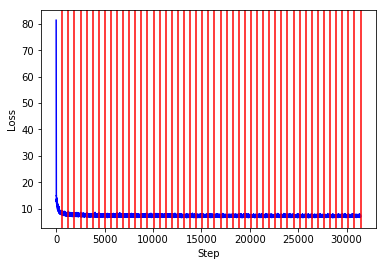

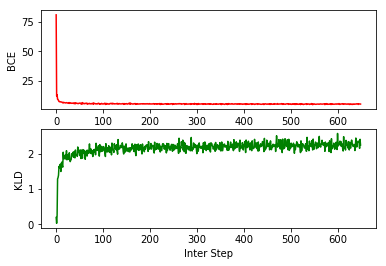

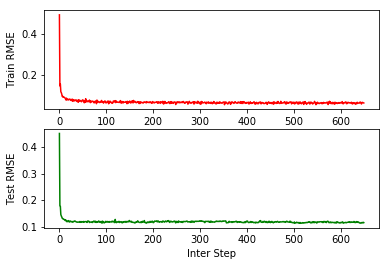

In [39]:
#tf.set_random_seed(123)
#np.random.seed(123)

from sklearn.metrics import mean_squared_error
from math import sqrt

# change as you change the input and output data
xtraining = XTrainM
xtesting =  XTestM
ytraining = XTrainM
ytesting =  XTestM

#input_dim = 116, out_dim = 23
input_dim = xtraining.shape[1]
output_dim = ytraining.shape[1]
labels_dim = 5


#num_hidden_vars = 10
num_hidden_vars = 23
f_activation = 'relu'

#k = 1  # dropout probability
cnn = config_nn_1c(num_hidden_vars, f_activation)

y = tf.placeholder(tf.float32, [None, output_dim], name='y')

# p(x|z)
#log_px_given_z = tf.nn.sigmoid_cross_entropy_with_logits(cnn['yhat'],y)
log_px_given_z = -tf.reduce_sum(
    y * tf.log(cnn['yhat'] + 1e-10) +
    (1 - y) * tf.log(1 - cnn['yhat'] + 1e-10), 1)

# d_kl(q(z|x)||p(z))
kl_div = -0.5 * tf.reduce_sum(
    1.0 + 2.0 * cnn['z_log_sigma'] - tf.square(cnn['z_mu']) - tf.exp(2.0 * cnn['z_log_sigma']),
    1)

KLD = tf.reduce_mean(kl_div)
BCE = tf.reduce_mean(log_px_given_z)
#BCE = tf.sqrt(tf.reduce_mean(tf.reduce_sum(tf.square(tf.sub(y,yhat)),1)))
#BCE = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(cnn['yhat'], y)) 

loss = KLD + BCE 


learning_rate = 0.001
train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

sess.run(tf.global_variables_initializer())

# Fit all training data
batch_size = 200
n_epochs = 50
print_step = 50


history = {'cost_h':[], 'train_rmse':[], 'test_rmse':[], 'kld':[], 'bce':[]}
for epoch in range(n_epochs):
    bt = BatchTrainGen(xtraining, batch_size)
    ini_offset = np.asscalar(np.random.randint(0,batch_size,1))
    bt.gen_offsets(ini_offset)
    # Loop over all batches
    for step in range(bt.batch_num):
        batch_xs, fold = bt.next_batch()
        batch_ys = ytraining[fold, :]
        batch_labels = YTrainAN5MOhe[fold, :]
        feed_dict = {cnn['labels']: batch_labels, cnn['x_ini']: batch_xs, y: batch_ys, K.learning_phase(): 1}
        cost, kld, bce, yhat, _ = sess.run([loss, KLD, BCE, cnn['yhat'], train_step], feed_dict = feed_dict)
        history['cost_h'].append(cost)

        if step % print_step == 0:
            batch_rmse = sqrt(mean_squared_error(batch_ys, yhat))
            test_rmse = sqrt(mean_squared_error(ytesting, 
                                                cnn['yhat'].eval(feed_dict={cnn['x_ini']: xtesting, 
                                                                            cnn['labels']: YTestAN5MOhe,
                                                                            K.learning_phase(): 0})))
            print("Epoch {0} |Step {1} | Loss: {2:.6f}| ".format(epoch,step,cost), end="")
            print("KLD: {0}| BCE: {1:.6f}| Train rmse: {2:.6f}| Test rmse: {3:.6f}".format(kld,
                                                                                           bce,
                                                                                           batch_rmse,
                                                                                           test_rmse))
            history['train_rmse'].append(batch_rmse)
            history['test_rmse'].append(test_rmse)
            history['kld'].append(kld)
            history['bce'].append(bce)


## Plot Loss
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history['cost_h'],'b-')
for xc in range(bt.batch_num,bt.batch_num*(n_epochs+1),bt.batch_num):
    plt.axvline(x=xc, color='r', linestyle='-')
plt.ylabel('Loss')
plt.xlabel('Step')
plt.show() 

## Plot kld and bce
plt.subplot(2, 1, 1)
plt.plot(history['bce'],'r-')
plt.ylabel('BCE')
plt.subplot(2, 1, 2)
plt.plot(history['kld'],'g-')
plt.ylabel('KLD')
plt.xlabel('Inter Step')
plt.show() 

## Plot Train Test rmse
plt.subplot(2, 1, 1)
plt.plot(history['train_rmse'],'r-')
plt.ylabel('Train RMSE')
plt.subplot(2, 1, 2)
plt.plot(history['test_rmse'],'g-')
plt.ylabel('Test RMSE')
plt.xlabel('Inter Step')
plt.show()   

## 2.5 Results to reproduce the input, using the autoencoder
#### Metrics to assess how well the autoencoder reproduce the input

In [40]:
XTestM_hat = cnn['yhat'].eval(feed_dict={cnn['x_ini']: xtesting, cnn['labels']: YTestAN5MOhe, K.learning_phase(): 0})
XTrainM_hat = cnn['yhat'].eval(feed_dict={cnn['x_ini']: xtraining, cnn['labels']: YTrainAN5MOhe, K.learning_phase(): 0})

print('\nPerformance measures. Training data')
print('RMSE Total=  {}'.format(sqrt(mean_squared_error(ytraining,XTrainM_hat ))))

print('Accuracy flags =  {}'.format(accuracy(XTrainM_hat[:,32:43], ytraining[:,32:43])))
print('Accuracy protocol =  {}'.format(accuracy(XTrainM_hat[:,43:46], ytraining[:,43:46])))
print('Accuracy service =  {}'.format(accuracy(XTrainM_hat[:,46:], ytraining[:,46:])))
print('RMSE Continous Vars =  {}'.format(sqrt(mean_squared_error(XTrainM_hat[:,:32], ytraining[:,:32]))))

print('\nPerformance measures. Test data')
print('RMSE Total =  {}'.format(sqrt(mean_squared_error(ytesting,XTestM_hat ))))

print('Accuracy flags =  {}'.format(accuracy(XTestM_hat[:,32:43], ytesting[:,32:43])))
print('Accuracy protocol =  {}'.format(accuracy(XTestM_hat[:,43:46], ytesting[:,43:46])))
print('Accuracy service =  {}'.format(accuracy(XTestM_hat[:,46:], ytesting[:,46:])))
print('RMSE Continous Vars =  {}'.format(sqrt(mean_squared_error(XTestM_hat[:,:32], ytesting[:,:32]))))


Performance measures. Training data
RMSE Total=  0.06052868224848146
Accuracy flags =  0.9968247164074842
Accuracy protocol =  0.9988172068617879
Accuracy service =  0.8221523659831869
RMSE Continous Vars =  0.08159766952508471

Performance measures. Test data
RMSE Total =  0.11648790059046915
Accuracy flags =  0.896735273243435
Accuracy protocol =  0.9798172462739532
Accuracy service =  0.7258694109297374
RMSE Continous Vars =  0.17059880086229948


## 2.6 Generate new XTrain (synthetic data) with the autoencoder
#### We generate a list of synthetic datasets using the already trained autoencoder

In [19]:
xtrain_hat_list = []
xtrain_hat_ohe_list = []
for i in range(10):
    xtrain_hat = cnn['yhat'].eval(feed_dict={cnn['x_ini']: xtraining, 
                                             cnn['labels']: YTrainAN5MOhe,
                                             K.learning_phase(): 0})
    xtrain_hat_list.append(xtrain_hat)
    t = np.copy(xtrain_hat)
    t[:,32:43] = labelOHEncodedFromPrediction(t[:,32:43])
    t[:,43:46] = labelOHEncodedFromPrediction(t[:,43:46])
    t[:,46:] = labelOHEncodedFromPrediction(t[:,46:])
    xtrain_hat_ohe_list.append(t)
    

In [ ]:
## Generate latent variables

In [20]:
zm = cnn['z_mu'].eval(feed_dict={cnn['x_ini']: xtraining, cnn['labels']: YTrainAN5MOhe, K.learning_phase(): 0})
zls = cnn['z_log_sigma'].eval(feed_dict={cnn['x_ini']: xtraining, cnn['labels']: YTrainAN5MOhe, K.learning_phase(): 0})

## 2.7 Analysis on synthetic datasets
### 2.7.1 Initial analysis

#### We perform an small analysis on the latent variables (mean and std) and the synthetic data. The intention is to be sure that the synthetic data is not constant, meaning that different synthetic datasets have differences and we are not generating always the same data, and at the same time the values means are close enough.

In [21]:
zm[1,:]

array([  1.62862428e-03,  -4.53347666e-03,   1.64576620e-02,
         1.29188458e-02,  -1.83749013e-04,   1.10685788e-02,
         1.49172889e-02,  -2.31703627e-03,   5.52912988e-03,
        -4.75560501e-03,  -8.58826004e-03,   4.28903289e-03,
        -1.08610699e-02,   1.78117037e+00,  -9.24355118e-04,
        -6.25635833e-02,   6.08443376e-03,   1.11910403e-02,
         2.39821151e-03,  -2.61436515e-02,  -3.21484637e-04,
         1.03170648e-02,   1.52780777e-02], dtype=float32)

In [23]:
print(np.mean(np.abs(xtrain_hat_list[1]-XTrainM)))
print(np.mean(np.abs(xtrain_hat_ohe_list[1]-XTrainM)))

0.0108696912259
0.0103770566881


In [24]:
#xrandom_hat_list = []
#xrandom_hat_ohe_list = []
#increase_std = 2
#for i in range(2):
#    zval = zm + np.exp(zls)*np.random.randn(zls.shape[0],zls.shape[1])*increase_std
#    xrandom_hat = cnn['yhat'].eval(feed_dict={cnn['z']: zval, 
#                                              cnn['labels']: YTrainAN5MOhe,
#                                              K.learning_phase(): 0})
#    xrandom_hat_list.append(xrandom_hat)
#    tt = np.copy(xrandom_hat)
#    tt[:,32:43] = labelOHEncodedFromPrediction(tt[:,32:43])
#    tt[:,43:46] = labelOHEncodedFromPrediction(tt[:,43:46])
#    tt[:,46:] = labelOHEncodedFromPrediction(tt[:,46:])
#    xrandom_hat_ohe_list.append(tt)
#    

In [25]:
xrandom_hat_list = []
xrandom_hat_ohe_list = []
for i in range(2):
    zval = np.random.randn(zls.shape[0],zls.shape[1])
    xrandom_hat = cnn['yhat'].eval(feed_dict={cnn['z']: zval, 
                                              cnn['labels']: YTrainAN5MOhe,
                                              K.learning_phase(): 0})
    xrandom_hat_list.append(xrandom_hat)
    tt = np.copy(xrandom_hat)
    tt[:,32:43] = labelOHEncodedFromPrediction(tt[:,32:43])
    tt[:,43:46] = labelOHEncodedFromPrediction(tt[:,43:46])
    tt[:,46:] = labelOHEncodedFromPrediction(tt[:,46:])
    xrandom_hat_ohe_list.append(tt)
    

In [26]:
np.mean(xrandom_hat_ohe_list[0]-xrandom_hat_ohe_list[1], axis=0)

array([  2.53854116e-04,  -2.55550811e-04,  -8.95823268e-06,
         1.87773330e-04,  -7.57610251e-05,  -1.41779301e-05,
         4.05853818e-04,   1.58386520e-05,  -4.14794304e-05,
         1.76914491e-05,  -1.13981823e-05,   5.65198752e-06,
        -1.53159432e-04,  -4.33204608e-04,  -6.97196054e-04,
         2.96309765e-04,   3.14912410e-04,  -9.70696783e-05,
         6.23511951e-05,  -2.77597806e-04,  -3.84413521e-04,
        -3.59767910e-05,   1.31621346e-04,  -8.12456012e-04,
        -1.21888786e-03,  -6.58169956e-05,   4.96593886e-04,
        -2.25852345e-04,   5.03728341e-04,   6.55885669e-04,
        -2.43972565e-04,   2.96935632e-05,  -1.58764178e-05,
         6.35056713e-05,  -6.50933129e-04,   9.52585106e-05,
         6.58871373e-04,   3.65157612e-04,  -1.58764175e-04,
        -3.17528356e-05,   1.58764178e-05,  -5.31859987e-04,
         1.90517021e-04,  -5.55674604e-04,   1.35743374e-03,
        -8.01759132e-04,   3.17528356e-05,   2.38146276e-05,
         1.68290036e-03,

In [27]:
np.mean(xtrain_hat_ohe_list[0]-xtrain_hat_ohe_list[1], axis=0)

array([ -1.57364339e-04,  -7.43638520e-05,   1.73711051e-05,
        -1.20248853e-06,  -3.75714262e-05,   3.33910475e-06,
        -1.82164280e-04,  -5.79292919e-06,  -2.46023010e-05,
        -1.42025674e-05,   6.61732372e-07,  -2.58194041e-06,
        -7.16243812e-05,   1.52956243e-04,   2.46578333e-04,
        -7.14142006e-05,  -6.22762600e-05,  -1.07010463e-04,
        -9.53097915e-05,  -1.70383864e-04,   9.82466954e-05,
         3.37622099e-04,   1.20146506e-04,   1.99702390e-05,
         1.25171791e-05,  -1.13001326e-04,  -2.23014081e-06,
         1.10295105e-05,  -4.16062248e-05,   2.85055958e-05,
        -2.90161523e-04,  -1.38462521e-04,   3.17528356e-05,
        -4.76292553e-05,  -6.35056713e-05,  -1.03196719e-04,
         1.19073135e-04,   1.58764175e-04,   1.58764178e-05,
        -1.11134927e-04,  -7.93820891e-06,   7.93820891e-06,
         0.00000000e+00,  -1.03196719e-04,  -1.34949558e-04,
         2.38146269e-04,  -7.93820891e-06,  -8.73202953e-05,
         8.73202953e-05,

In [28]:
np.std(xtrain_hat_ohe_list[0]-xtrain_hat_ohe_list[1], axis=0)

array([ 0.04401384,  0.01778765,  0.02849862,  0.01742409,  0.00775904,
        0.00162832,  0.06708647,  0.00722155,  0.01234887,  0.00721251,
        0.0025027 ,  0.00261542,  0.02226147,  0.0597754 ,  0.05235079,
        0.03147555,  0.03054944,  0.02929157,  0.02940042,  0.05996125,
        0.05002676,  0.09336696,  0.07270679,  0.04553674,  0.07471576,
        0.03929301,  0.0738923 ,  0.03215471,  0.02196725,  0.02484349,
        0.04830188,  0.03061051,  0.01054196,  0.05301058,  0.04663756,
        0.0180401 ,  0.03530256,  0.03261396,  0.03187617,  0.01868841,
        0.00281746,  0.04207399,  0.01736813,  0.05293549,  0.05172176,
        0.06082015,  0.01351217,  0.01889985,  0.26464826,  0.        ,
        0.05040006,  0.02423689,  0.02374032,  0.04159963,  0.04033953,
        0.0496069 ,  0.04748102,  0.03673548,  0.05649028,  0.        ,
        0.05330928,  0.04382956,  0.        ,  0.00690136,  0.11262874,
        0.05094858,  0.11213397,  0.03541503,  0.        ,  0.  

In [29]:
np.mean(xrandom_hat_ohe_list[1][:,32:], axis = 0)

array([  5.79489279e-04,   7.55161792e-02,   1.63368341e-02,
         9.84337879e-04,   1.90993305e-02,   2.75416166e-01,
         4.92168963e-03,   1.19866955e-03,   4.76292553e-05,
         6.02573574e-01,   3.32610961e-03,   8.00250843e-02,
         8.13182175e-01,   1.06792726e-01,   2.84981704e-03,
         4.12786874e-04,   4.98916432e-02,   0.00000000e+00,
         4.72323457e-03,   1.27011340e-03,   2.85775517e-04,
         1.46063045e-03,   5.95365651e-04,   1.30186626e-03,
         2.18300754e-03,   1.99249038e-03,   5.72583005e-02,
         0.00000000e+00,   4.57637757e-02,   2.81330124e-02,
         0.00000000e+00,   1.42887759e-04,   2.39575151e-02,
         1.27725778e-02,   6.15528710e-02,   4.36601491e-04,
         0.00000000e+00,   0.00000000e+00,   3.28046501e-01,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         6.90624176e-04,   1.86547916e-03,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   2.10362533e-03,
         2.38146276e-05,

In [30]:
np.mean(xtrain_hat_ohe_list[1][:,32:], axis = 0)

array([  2.93713732e-04,   8.84951502e-02,   1.28440224e-02,
         9.68461507e-04,   1.93771683e-02,   2.76670396e-01,
         3.04033398e-03,   9.52585076e-04,   3.17528356e-05,
         5.95048130e-01,   2.27826601e-03,   6.55378550e-02,
         8.15000057e-01,   1.19462110e-01,   1.07959646e-03,
         2.54022685e-04,   5.90523370e-02,   0.00000000e+00,
         3.47693544e-03,   1.35743374e-03,   3.41342995e-04,
         1.09547284e-03,   1.08753459e-03,   1.96867576e-03,
         2.43703020e-03,   9.60523263e-04,   7.15708956e-02,
         0.00000000e+00,   3.70238051e-02,   2.39019468e-02,
         0.00000000e+00,   3.17528356e-05,   1.74402446e-02,
         1.16453525e-02,   5.56071550e-02,   6.19180326e-04,
         0.00000000e+00,   0.00000000e+00,   3.20529014e-01,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         1.20660779e-03,   1.00815250e-03,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   2.81806430e-03,
         7.93820891e-06,

### 2.7.2 Statistics to demonstrate difference between original and synthetic data (XTrain and XGenerated)

In [1]:
## Matrices with value difference between original and different instances of synthetic data

In [31]:
dif1 = XTrainM - xrandom_hat_ohe_list[0]
dif2 = XTrainM - xrandom_hat_ohe_list[1]

In [37]:
print(np.mean(dif1))
print(np.mean(dif2))
print(np.std(dif1))
print(np.std(dif2))

0.000128293753306
0.000113852546065
0.208174338136
0.208323113113


In [38]:
dif1.shape[1]

116

In [39]:
len(list(XTrain.columns.values))

116

In [40]:
print(np.mean(dif1[:,0]))
print(np.mean(dif1[:,1]))
print(np.std(dif1[:,0]))
print(np.std(dif1[:,1]))
m1 = np.empty((0,2))
for i in range (dif1.shape[1]):
    m1 = np.vstack((m1, np.array([np.mean(dif1[:,i]),np.std(dif1[:,i])])))
m1 = pd.DataFrame(np.hstack((np.array(list(XTrain.columns.values))[:,np.newaxis], m1)))

-0.00112650096503
-0.0043833233018
0.170636837517
0.130631590936


In [116]:
m1  # matrix with mean and std for the diff between original and synthetic

0                        1  \
0                       duration   -0.0026639137773956383   
1                      src_bytes    -0.003312199640092166   
2                      dst_bytes    0.0029063208425403535   
3                 wrong_fragment    5.674947158483784e-05   
4                            hot   -0.0004104700413064443   
5              num_failed_logins  -0.00016108891819148802   
6                      logged_in     0.001371983109004293   
7                num_compromised   -0.0007923211391342557   
8                     root_shell    -0.001531307378497368   
9                       num_root   -0.0005174473489202923   
10            num_file_creations  -0.00012098197749059435   
11              num_access_files  -0.00030569784561272097   
12                is_guest_login    0.0008778840378430471   
13                         count     0.025303377986544758   
14                     srv_count     0.004864089804570495   
15                   serror_rate     0.007960552660464405   
16               srv_serror_rate     0.006442141100297189   
17                   rerror_rate     0.006079703015271696   
18               srv_rerror_rate     0.007524142594630532   
19                 same_srv_rate    -0.005218265140163187   
20                 diff_srv_rate   -0.0008257636523508596   
21            srv_diff_host_rate    -0.024898798945022883   
22                dst_host_count     0.017486940714292163   
23            dst_host_srv_count   0.00032121172001225485   
24        dst_host_same_srv_rate    -0.008122988317253966   
25        dst_host_diff_srv_rate       0.0102600310149377   
26   dst_host_same_src_port_rate    -0.012270504169620722   
27   dst_host_srv_diff_host_rate    -0.007965043065154265   
28          dst_host_serror_rate     0.009225223940473952   
29      dst_host_srv_serror_rate      0.00889609468500927   
..                           ...                      ...   
86               service=netstat    0.0026672382177133193   
87                  service=nnsp    -0.041548585808069985   
88                  service=nntp    0.0023497098584617337   
89                 service=ntp_u   -0.0007620680622038056   
90                 service=other   0.00046041612091479923   
91               service=pm_dump   3.1752835925158565e-05   
92                 service=pop_2    0.0006191803005405921   
93                 service=pop_3   -7.938208981289641e-06   
94               service=printer    0.0005477364197089853   
95               service=private     -0.01754344184865011   
96                 service=red_i    6.350567185031713e-05   
97            service=remote_job    0.0006191803005405921   
98                   service=rje    0.0006826859723909092   
99                 service=shell    0.0003254665682328753   
100                 service=smtp    -0.009446468687734673   
101              service=sql_net    0.0019448612004159622   
102                  service=ssh    0.0019527994093972518   
103               service=sunrpc    0.0020401197081914377   
104               service=supdup     0.004262818222952537   
105               service=systat    0.0027386820985449262   
106               service=telnet    -0.004302509267858985   
107               service=tftp_u   2.3814626943868923e-05   
108                service=tim_i   -4.762925388773785e-05   
109                 service=time    0.0028974462781707192   
110                service=urh_i    7.938208981289641e-05   
111                service=urp_i   -0.0005636128376715645   
112                 service=uucp    -0.011812054964158986   
113            service=uucp_path    0.0033737388170480974   
114                service=vmnet    0.0020639343351353066   
115                service=whois     0.004334262103784144   

                         2  
0      0.17064227431332768  
1       0.1288903950543291  
2      0.14660580779214774  
3      0.11378913232584968  
4      0.03544094846446276  
5     0.010120535784557873  
6        0.481734397731812  
7      0.0248017

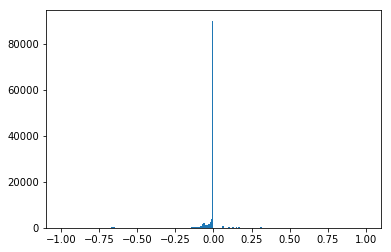

In [132]:
%matplotlib inline

from matplotlib import pyplot as plt

plt.hist(dif1[:,0],256,[-1,1]); 
plt.show()

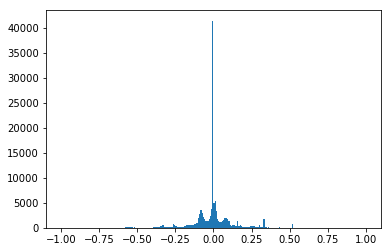

In [133]:


from matplotlib import pyplot as plt

plt.hist(dif1[:,1],256,[-1,1]); 
plt.show()

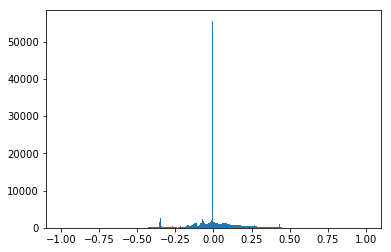

In [134]:
from matplotlib import pyplot as plt

plt.hist(dif1[:,2],256,[-1,1]); 
plt.show()

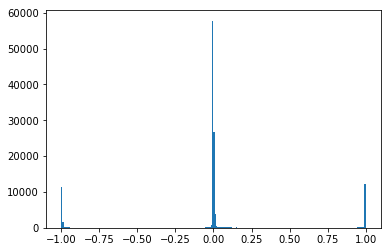

In [157]:
from matplotlib import pyplot as plt

plt.hist(dif1[:,6],256,[-1,1]); 
plt.show()

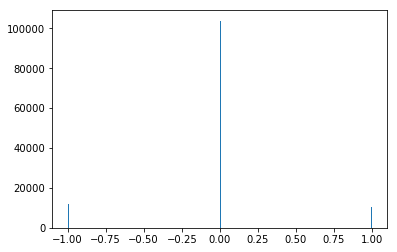

In [136]:
from matplotlib import pyplot as plt

plt.hist(dif1[:,41],256,[-1,1]); 
plt.show()

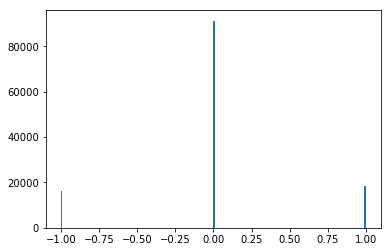

In [137]:
from matplotlib import pyplot as plt

plt.hist(dif1[:,44],256,[-1,1]); 
plt.show()

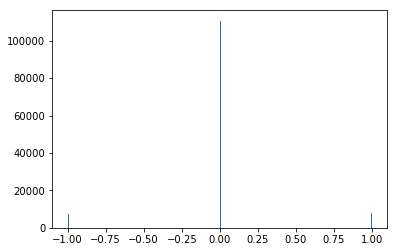

In [138]:
from matplotlib import pyplot as plt

plt.hist(dif1[:,58],256,[-1,1]); 
plt.show()

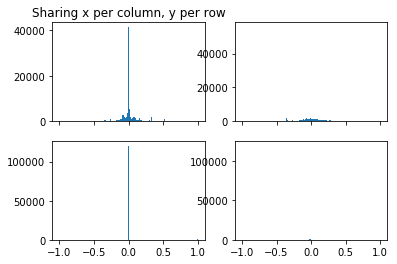

In [139]:
from matplotlib import pyplot as plt

# row and column sharing
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col')
ax1.hist(dif1[:,1],256,[-1,1]); 
ax1.set_title('Sharing x per column, y per row')
ax2.hist(dif1[:,2],256,[-1,1]); 
ax3.hist(dif1[:,3],256,[-1,1]); 
ax4.hist(dif1[:,4],256,[-1,1]); 
#f.subplots_adjust(vspace=1.5)

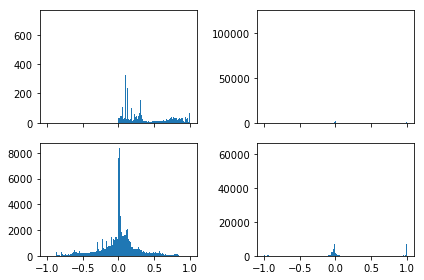

In [123]:
from matplotlib import pyplot as plt

# row and column sharing
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col')
ax1.hist(dif1[:,0],256,[0,1]); 
#ax1.set_title('Sharing x per column, y per row')
ax2.hist(dif1[:,3],256,[-1,1]); 
ax3.hist(dif1[:,23],256,[-1,1]); 
ax4.hist(dif1[:,30],256,[-1,1]); 
#f.subplots_adjust(wspace=0.3)
f.tight_layout() # Or equivalently,  "plt.tight_layout()"

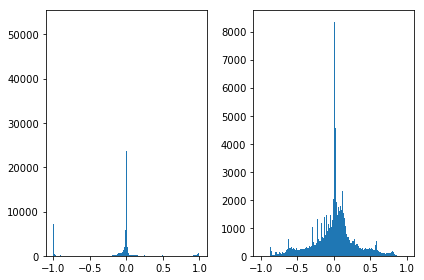

In [122]:
from matplotlib import pyplot as plt

# row and column sharing
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(dif1[:,28],256,[-1,1]); 
#ax1.set_title('Sharing x per column, y per row')
ax2.hist(dif1[:,23],256,[-1,1]); 
f.tight_layout() # Or equivalently,  "plt.tight_layout()"

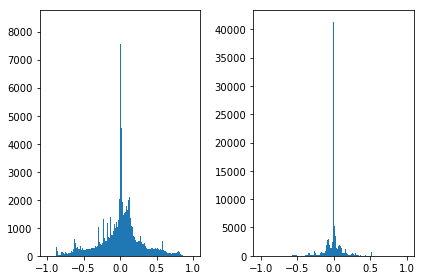

In [131]:
from matplotlib import pyplot as plt

# row and column sharing
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(dif1[:,23],256,[-1,1]); 
#ax1.set_title('Sharing x per column, y per row')
ax2.hist(dif1[:,1],256,[-1,1]); 
f.tight_layout() # Or equivalently,  "plt.tight_layout()"

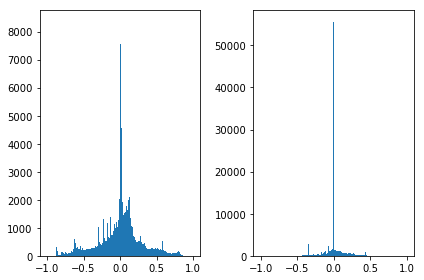

In [127]:
from matplotlib import pyplot as plt

# row and column sharing
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(dif1[:,23],256,[-1,1]); 
#ax1.set_title('Sharing x per column, y per row')
ax2.hist(dif1[:,2],256,[-1,1]); 
f.tight_layout() # Or equivalently,  "plt.tight_layout()"

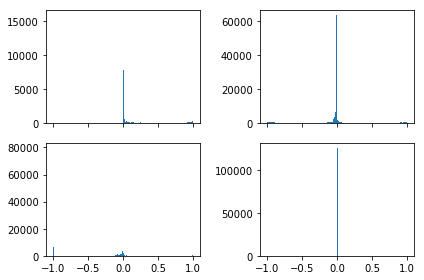

In [120]:
from matplotlib import pyplot as plt

# row and column sharing
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col')
ax1.hist(dif1[:,28],256,[0,1]); 
#ax1.set_title('Sharing x per column, y per row')
ax2.hist(dif1[:,30],256,[-1,1]); 
ax3.hist(dif1[:,31],256,[-1,1]); 
ax4.hist(dif1[:,59],256,[-1,1]); 
#f.subplots_adjust(wspace=0.3)
f.tight_layout() # Or equivalently,  "plt.tight_layout()"

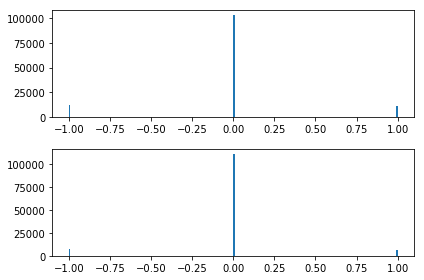

In [43]:
from matplotlib import pyplot as plt

# row and column sharing
f, (ax1, ax2) = plt.subplots(2,1)
ax1.hist(dif1[:,41],256,[-1,1]); 
#ax1.set_title('Sharing x per column, y per row')
ax2.hist(dif1[:,43],256,[-1,1]); 
f.tight_layout() # Or equivalently,  "plt.tight_layout()"

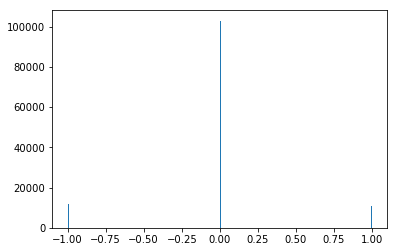

In [41]:
from matplotlib import pyplot as plt

# row and column sharing

plt.hist(dif1[:,41],256,[-1,1]); 
f.tight_layout() # Or equivalently,  "plt.tight_layout()"

## 2.8  Prediction results using real and synthetic data for both training and testing 
## NO Data Augmentation
#### Here the intention is to check that using the real or synthetic data either at training or test times does not change results. That is, to check if new synthetic XTrain have the same behaviour as the original

### 2.8.1. - Using prediction algorithm: Logistic Regression

In [30]:
# multinomial logistic regression
xtrain = XTrainM
xtest = xrandom_hat_ohe_list[1]

clf = LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

clf.fit(xtrain, YTrainAN5)

y_hat = clf.predict(xtest)
print('\nTraining data.2-fold CV. Train w/Real --> Predict w/Fake')
print('Accuracy =  {}'.format(accuracy_score(YTrainAN5, y_hat)))

y_hat = clf.predict(xtrain)
print('\nTraining data.2-fold CV. Train w/Real --> Predict w/Real')
print('Accuracy =  {}'.format(accuracy_score(YTrainAN5, y_hat)))

clf.fit(xtest, YTrainAN5)

y_hat = clf.predict(xtrain)
print('\nTraining data.2-fold CV. Train w/Fake --> Predict w/Train')
print('Accuracy =  {}'.format(accuracy_score(YTrainAN5, y_hat)))

y_hat = clf.predict(xtest)
print('\nTraining data.2-fold CV. Train w/Fake --> Predict w/Fake')
print('Accuracy =  {}'.format(accuracy_score(YTrainAN5, y_hat)))


Training data.2-fold CV. Train w/Real --> Predict w/Fake
Accuracy =  0.9927286005731387

Training data.2-fold CV. Train w/Real --> Predict w/Real
Accuracy =  0.9931731402760909

Training data.2-fold CV. Train w/Fake --> Predict w/Train
Accuracy =  0.9472744159462742

Training data.2-fold CV. Train w/Fake --> Predict w/Fake
Accuracy =  0.9994919546251975


### 2.8.2. - Using prediction algorithm: Random Forest

In [31]:
# random forest
from sklearn.ensemble import RandomForestClassifier
xtrain = XTrainM
xtest = xrandom_hat_ohe_list[1]

clf = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=501, n_jobs=1,
            oob_score=True, random_state=123, verbose=0, warm_start=False)

clf.fit(xtrain, YTrainAN5)

y_hat = clf.predict(xtest)
print('\nTraining data.2-fold CV. Train w/Real --> Predict w/Fake')
print('Accuracy =  {}'.format(accuracy_score(YTrainAN5, y_hat)))

y_hat = clf.predict(xtrain)
print('\nTraining data.2-fold CV. Train w/Real --> Predict w/Real')
print('Accuracy =  {}'.format(accuracy_score(YTrainAN5, y_hat)))

clf.fit(xtest, YTrainAN5)

y_hat = clf.predict(xtrain)
print('\nTraining data.2-fold CV. Train w/Fake --> Predict w/Train')
print('Accuracy =  {}'.format(accuracy_score(YTrainAN5, y_hat)))

y_hat = clf.predict(xtest)
print('\nTraining data.2-fold CV. Train w/Fake --> Predict w/Fake')
print('Accuracy =  {}'.format(accuracy_score(YTrainAN5, y_hat)))


Training data.2-fold CV. Train w/Real --> Predict w/Fake
Accuracy =  0.9857271002516412

Training data.2-fold CV. Train w/Real --> Predict w/Real
Accuracy =  0.9998571122383367

Training data.2-fold CV. Train w/Fake --> Predict w/Train
Accuracy =  0.9526565216355886

Training data.2-fold CV. Train w/Fake --> Predict w/Fake
Accuracy =  1.0


### 2.8.3. - Using prediction algorithm: Neural Network

In [32]:
# Neural Net
from sklearn.neural_network import MLPClassifier
xtrain = XTrainM
xtest = xrandom_hat_ohe_list[1]

clf = MLPClassifier(solver='adam', alpha=1e-5,
                     hidden_layer_sizes=(200, 50), random_state=1)

clf.fit(xtrain, YTrainAN5)

y_hat = clf.predict(xtest)
print('\nTraining data.2-fold CV. Train w/Real --> Predict w/Fake')
print('Accuracy =  {}'.format(accuracy_score(YTrainAN5, y_hat)))

y_hat = clf.predict(xtrain)
print('\nTraining data.2-fold CV. Train w/Real --> Predict w/Real')
print('Accuracy =  {}'.format(accuracy_score(YTrainAN5, y_hat)))

clf.fit(xtest, YTrainAN5)

y_hat = clf.predict(xtrain)
print('\nTraining data.2-fold CV. Train w/Fake --> Predict w/Train')
print('Accuracy =  {}'.format(accuracy_score(YTrainAN5, y_hat)))

y_hat = clf.predict(xtest)
print('\nTraining data.2-fold CV. Train w/Fake --> Predict w/Fake')
print('Accuracy =  {}'.format(accuracy_score(YTrainAN5, y_hat)))




Training data.2-fold CV. Train w/Real --> Predict w/Fake
Accuracy =  0.996546879093139

Training data.2-fold CV. Train w/Real --> Predict w/Real
Accuracy =  0.999039476713264

Training data.2-fold CV. Train w/Fake --> Predict w/Train
Accuracy =  0.9636350646567121

Training data.2-fold CV. Train w/Fake --> Predict w/Fake
Accuracy =  0.9999761853730561


### 2.8.4. - Using prediction algorithm: Linear SVM

In [33]:
# random forest
from sklearn.svm import LinearSVC   

xtrain = XTrainM
xtest = xrandom_hat_ohe_list[1]

clf = LinearSVC(C=1000, class_weight='balanced', dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

clf.fit(xtrain, YTrainAN5)

y_hat = clf.predict(xtest)
print('\nTraining data.2-fold CV. Train w/Real --> Predict w/Fake')
print('Accuracy =  {}'.format(accuracy_score(YTrainAN5, y_hat)))

y_hat = clf.predict(xtrain)
print('\nTraining data.2-fold CV. Train w/Real --> Predict w/Real')
print('Accuracy =  {}'.format(accuracy_score(YTrainAN5, y_hat)))

clf.fit(xtest, YTrainAN5)

y_hat = clf.predict(xtrain)
print('\nTraining data.2-fold CV. Train w/Fake --> Predict w/Train')
print('Accuracy =  {}'.format(accuracy_score(YTrainAN5, y_hat)))

y_hat = clf.predict(xtest)
print('\nTraining data.2-fold CV. Train w/Fake --> Predict w/Fake')
print('Accuracy =  {}'.format(accuracy_score(YTrainAN5, y_hat)))


Training data.2-fold CV. Train w/Real --> Predict w/Fake
Accuracy =  0.9867114381653211

Training data.2-fold CV. Train w/Real --> Predict w/Real
Accuracy =  0.9843061608439904

Training data.2-fold CV. Train w/Fake --> Predict w/Train
Accuracy =  0.9363673168059823

Training data.2-fold CV. Train w/Fake --> Predict w/Fake
Accuracy =  0.9995792749239917


## 2.9  Prediction results using real and synthetic data for  training 
## WITH Data Augmentation (1 x Original + 1 x Synthetic)
#### Check prediction improvement when increasing training data with additional synthetic data. We use as training data the original real data plus an instance of synthetic data  of same size as original data. Having finally 2x the number of samples that we had originally in the real data.

In [34]:

from sklearn.ensemble import RandomForestClassifier
xtrain1 = XTrainM
xtest = XTestM

xtrain2 = np.append(XTrainM, xrandom_hat_ohe_list[1], axis=0)
YTrain2 = np.append(YTrainAN5, YTrainAN5, axis=0)

### 2.9.1 - Using prediction algorithm: Random Forest

In [35]:
# random forest
clf = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=501, n_jobs=1,
            oob_score=True, random_state=123, verbose=0, warm_start=False)

clf.fit(xtrain1, YTrainAN5)

y_hat = clf.predict(xtest)
print('\nPrediction with original data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


clf.fit(xtrain2, YTrain2)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


Prediction with original data for training
Accuracy =  0.7303938963804116

Prediction with augmented data for training
Accuracy =  0.7357611781405252


### 2.9.2 - Using prediction algorithm: Logistic Regression

In [36]:
# multinomial logistic regression

clf = LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

clf.fit(xtrain1, YTrainAN5)

y_hat = clf.predict(xtest)
print('\nPrediction with original data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


clf.fit(xtrain2, YTrain2)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


Prediction with original data for training
Accuracy =  0.73624911284599

Prediction with augmented data for training
Accuracy =  0.7610894251242015


### 2.9.3 - Using prediction algorithm: Linear SVM

In [37]:
# linear SVC
from sklearn.svm import LinearSVC   


clf = LinearSVC(C=1000, class_weight='balanced', dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

clf.fit(xtrain1, YTrainAN5)

y_hat = clf.predict(xtest)
print('\nPrediction with original data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


clf.fit(xtrain2, YTrain2)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


Prediction with original data for training
Accuracy =  0.7386444286728177

Prediction with augmented data for training
Accuracy =  0.7512863733144074


### 2.9.4 - Using prediction algorithm: MLP

In [38]:
# MLP
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='adam', alpha=1e-5,
                     hidden_layer_sizes=(200, 50), random_state=1)

clf.fit(xtrain1, YTrainAN5)

y_hat = clf.predict(xtest)
print('\nPrediction with original data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


clf.fit(xtrain2, YTrain2)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


Prediction with original data for training
Accuracy =  0.7752395315826828

Prediction with augmented data for training
Accuracy =  0.78388928317956


## 2.10  Prediction results using real and synthetic data for  training 
## WITH Data Augmentation (1 x Original + 2 x Synthetic)
#### Check prediction improvement when increasing training data with additional synthetic data. We use as training data the original real data plus two instances of synthetic data of same size as original data. Having finally 3x the number of samples that we had originally in the real data.


In [39]:

from sklearn.ensemble import RandomForestClassifier
xtrain1 = XTrainM
xtest = XTestM

xtrain2 = np.append(np.append(XTrainM, xrandom_hat_ohe_list[1], axis=0),xrandom_hat_ohe_list[0], axis=0)
YTrain2 = np.append(np.append(YTrainAN5, YTrainAN5, axis=0),YTrainAN5, axis=0)

### 2.10.1 - Using prediction algorithm: Random Forest

In [40]:
# random forest
clf = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=501, n_jobs=1,
            oob_score=True, random_state=123, verbose=0, warm_start=False)

clf.fit(xtrain1, YTrainAN5)

y_hat = clf.predict(xtest)
print('\nPrediction with original data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


clf.fit(xtrain2, YTrain2)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


Prediction with original data for training
Accuracy =  0.7303938963804116

Prediction with augmented data for training
Accuracy =  0.7348296664300923


### 2.10.2 - Using prediction algorithm: Logistic Regression

In [41]:
# multinomial logistic regression

clf = LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

clf.fit(xtrain1, YTrainAN5)

y_hat = clf.predict(xtest)
print('\nPrediction with original data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


clf.fit(xtrain2, YTrain2)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


Prediction with original data for training
Accuracy =  0.73624911284599

Prediction with augmented data for training
Accuracy =  0.7622870830376153


### 2.10.3 - Using prediction algorithm: Linear SVM

In [42]:
# linear SVC
from sklearn.svm import LinearSVC   


clf = LinearSVC(C=1000, class_weight='balanced', dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

clf.fit(xtrain1, YTrainAN5)

y_hat = clf.predict(xtest)
print('\nPrediction with original data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


clf.fit(xtrain2, YTrain2)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


Prediction with original data for training
Accuracy =  0.7386444286728177

Prediction with augmented data for training
Accuracy =  0.7447657913413769


### 2.10.4 - Using prediction algorithm: MLP

In [43]:
# MLP
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='adam', alpha=1e-5,
                     hidden_layer_sizes=(200, 50), random_state=1)

clf.fit(xtrain1, YTrainAN5)

y_hat = clf.predict(xtest)
print('\nPrediction with original data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


clf.fit(xtrain2, YTrain2)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


Prediction with original data for training
Accuracy =  0.7752395315826828

Prediction with augmented data for training
Accuracy =  0.785929737402413


## 2.11  Prediction results using real and synthetic data for  training 
## WITH Data Augmentation (1 x Original + 1 x Synthetic-label-balanced)
#### Check prediction improvement when increasing training data with additional synthetic data. We use as training data the original real data plus one instance of synthetic data of a different size and label distribution of the original data. We try to compensate in this way the label unbalanced of the original data.

In [41]:
labels_to_generate=np.append(np.append(np.append(np.array(['DOS']*21000).flatten(),
                             np.array(['PROBE']*55000).flatten()),
                             np.array(['R2L']*66000).flatten()
                            ),np.array(['U2R']*67000).flatten())

labels_to_generate_ohe = lb5.transform(labels_to_generate)

#labels_to_generate=np.append(np.append(np.append(np.array(['DOS']*20).flatten(),
#                             np.array(['PROBE']*20).flatten()),
#                             np.array(['R2L']*20).flatten()
#                            ),np.array(['U2R']*20).flatten())
#
#xtraining_new = lb5.transform(labels_to_generate)
zval = np.random.randn(len(labels_to_generate),num_hidden_vars)
xtrain_new = cnn['yhat'].eval(feed_dict={cnn['z']: zval, 
                                          cnn['labels']: labels_to_generate_ohe,
                                          K.learning_phase(): 0})
xtrain_new[:,32:43] = labelOHEncodedFromPrediction(xtrain_new[:,32:43])

xtrain_new[:,43:46] = labelOHEncodedFromPrediction(xtrain_new[:,43:46])

xtrain_new[:,46:] = labelOHEncodedFromPrediction(xtrain_new[:,46:])

xtrain3 = np.append(XTrainM, xtrain_new, axis=0)
YTrain3 = np.append(YTrainAN5,labels_to_generate)
xtest = XTestM

In [42]:
len(labels_to_generate)

209000

### 2.11.1 - Using prediction algorithm: MLP

In [43]:
# MLP
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='adam', alpha=1e-5,
                     hidden_layer_sizes=(200, 50), random_state=1)

clf.fit(xtrain3, YTrain3)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))
print('F1 =  {}'.format(f1_score(YTestAN5, y_hat, average='weighted')))



Prediction with augmented data for training
Accuracy =  0.7857966643009227
F1 =  0.7555053678680375


### 2.11.2 - Using prediction algorithm: Linear SVM

In [44]:
# linear SVC
from sklearn.svm import LinearSVC   


clf = LinearSVC(C=1000, class_weight='balanced', dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

clf.fit(xtrain3, YTrain3)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))
print('F1 =  {}'.format(f1_score(YTestAN5, y_hat, average='weighted')))


Prediction with augmented data for training
Accuracy =  0.7740862313697658
F1 =  0.7578191684416464


### 2.11.3 - Using prediction algorithm: Logistic Regression

In [45]:
# logistic regression
from sklearn.linear_model import LogisticRegression   


clf = LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

clf.fit(xtrain3, YTrain3)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))
print('F1 =  {}'.format(f1_score(YTestAN5, y_hat, average='weighted')))


Prediction with augmented data for training
Accuracy =  0.7761266855926189
F1 =  0.7534078550174281


### 2.11.4 - Using prediction algorithm: Random Forest

In [46]:
# random forest
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=501, n_jobs=1,
            oob_score=True, random_state=123, verbose=0, warm_start=False)

clf.fit(xtrain3, YTrain3)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))
print('F1 =  {}'.format(f1_score(YTestAN5, y_hat, average='weighted')))


Prediction with augmented data for training
Accuracy =  0.7349627395315826
F1 =  0.689236594748514


d:\Anaconda\envs\tensorflow2-gpu\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## 2.12  Prediction results using real and synthetic data for  training 
## WITH Data Augmentation (1 x Original + 1 x Synthetic-label-balanced)
#### Check prediction improvement when increasing training data with additional synthetic data. We use as training data the original real data plus one instance of synthetic data of a different size and label distribution of the original data. We try to compensate in this way the label unbalanced of the original data.
#### Different synthetic data sizes and label distribution

In [47]:
amp = 0
labels_to_generate=np.append(np.append(np.append(np.array(['DOS']*(21000+amp)).flatten(),
                             np.array(['PROBE']*(55000+amp)).flatten()),
                             np.array(['R2L']*(66000+amp)).flatten()
                            ),np.array(['U2R']*(67000+amp)).flatten())

labels_to_generate_ohe = lb5.transform(labels_to_generate)

#labels_to_generate=np.append(np.append(np.append(np.array(['DOS']*20).flatten(),
#                             np.array(['PROBE']*20).flatten()),
#                             np.array(['R2L']*20).flatten()
#                            ),np.array(['U2R']*20).flatten())
#
#xtraining_new = lb5.transform(labels_to_generate)
zval = np.random.randn(len(labels_to_generate),num_hidden_vars)
xtrain_new = cnn['yhat'].eval(feed_dict={cnn['z']: zval, 
                                          cnn['labels']: labels_to_generate_ohe,
                                          K.learning_phase(): 0})
xtrain_new[:,32:43] = labelOHEncodedFromPrediction(xtrain_new[:,32:43])

xtrain_new[:,43:46] = labelOHEncodedFromPrediction(xtrain_new[:,43:46])

xtrain_new[:,46:] = labelOHEncodedFromPrediction(xtrain_new[:,46:])

xtrain31 = np.append(XTrainM, xtrain_new, axis=0)
YTrain31 = np.append(YTrainAN5,labels_to_generate)
xtest = XTestM

In [48]:
len(labels_to_generate)

209000

### 2.12.1 - Using prediction algorithm: MLP

In [49]:
# MLP
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='adam', alpha=1e-5,
                     hidden_layer_sizes=(200, 50), random_state=1)

clf.fit(xtrain31, YTrain31)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))
print('F1 =  {}'.format(f1_score(YTestAN5, y_hat, average='weighted')))



Prediction with augmented data for training
Accuracy =  0.7862845990063875
F1 =  0.7583686691235779


### 2.12.2 - Using prediction algorithm: Linear SVM

In [50]:
# linear SVC
from sklearn.svm import LinearSVC   


clf = LinearSVC(C=1000, class_weight='balanced', dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

clf.fit(xtrain31, YTrain31)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))
print('F1 =  {}'.format(f1_score(YTestAN5, y_hat, average='weighted')))


Prediction with augmented data for training
Accuracy =  0.7738200851667849
F1 =  0.7573734025725295


### 2.12.3 - Using prediction algorithm: Logistic Regression

In [51]:
# logistic regression
from sklearn.linear_model import LogisticRegression   


clf = LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

clf.fit(xtrain31, YTrain31)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))
print('F1 =  {}'.format(f1_score(YTestAN5, y_hat, average='weighted')))


Prediction with augmented data for training
Accuracy =  0.7738200851667849
F1 =  0.7506058650067676


### 2.12.4 - Using prediction algorithm: Random Forest

In [52]:
# random forest
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=501, n_jobs=1,
            oob_score=True, random_state=123, verbose=0, warm_start=False)

clf.fit(xtrain31, YTrain31)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))
print('F1 =  {}'.format(f1_score(YTestAN5, y_hat, average='weighted')))


Prediction with augmented data for training
Accuracy =  0.7354950319375444
F1 =  0.6894840595295604


## 2.13  Prediction results using real and synthetic data for  training 
## WITH Data Augmentation (1 x Original + 1 x Synthetic-label-balanced)
#### Check prediction improvement when increasing training data with additional synthetic data. We use as training data the original real data plus one instance of synthetic data of a different size and label distribution of the original data. We try to compensate in this way the label unbalanced of the original data.
#### Different synthetic data sizes and label distribution

In [53]:
labels_to_generate=np.append(np.append(np.append(np.array(['DOS']*21000).flatten(),
                             np.array(['PROBE']*55000).flatten()),
                             np.array(['R2L']*66000).flatten()
                            ),np.array(['U2R']*67000).flatten())

labels_to_generate_ohe = lb5.transform(labels_to_generate)

#labels_to_generate=np.append(np.append(np.append(np.array(['DOS']*20).flatten(),
#                             np.array(['PROBE']*20).flatten()),
#                             np.array(['R2L']*20).flatten()
#                            ),np.array(['U2R']*20).flatten())
#
#xtraining_new = lb5.transform(labels_to_generate)
zval = np.random.randn(len(labels_to_generate),num_hidden_vars)
xtrain_new = cnn['yhat'].eval(feed_dict={cnn['z']: zval, 
                                          cnn['labels']: labels_to_generate_ohe,
                                          K.learning_phase(): 0})
xtrain_new[:,32:43] = labelOHEncodedFromPrediction(xtrain_new[:,32:43])

xtrain_new[:,43:46] = labelOHEncodedFromPrediction(xtrain_new[:,43:46])

xtrain_new[:,46:] = labelOHEncodedFromPrediction(xtrain_new[:,46:])

xtrain3 = np.append(XTrainM, xtrain_new, axis=0)
YTrain3 = np.append(YTrainAN5,labels_to_generate)
xtest = XTestM

In [54]:
len(labels_to_generate)

209000

### 2.13.1 - Using prediction algorithm: MLP

In [55]:
# MLP
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='adam', alpha=1e-5,
                     hidden_layer_sizes=(200, 50), random_state=1)

clf.fit(xtrain3, YTrain3)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))
print('F1 =  {}'.format(f1_score(YTestAN5, y_hat, average='weighted')))



Prediction with augmented data for training
Accuracy =  0.7880589070262598
F1 =  0.7611583961281716


### 2.13.2 - Using prediction algorithm: Linear SVM

In [56]:
# linear SVC
from sklearn.svm import LinearSVC   


clf = LinearSVC(C=1000, class_weight='balanced', dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

clf.fit(xtrain3, YTrain3)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))
print('F1 =  {}'.format(f1_score(YTestAN5, y_hat, average='weighted')))


Prediction with augmented data for training
Accuracy =  0.7665454222853088
F1 =  0.7505311058880064


### 2.13.3 - Using prediction algorithm: Logistic Regression

In [57]:
# logistic regression
from sklearn.linear_model import LogisticRegression   


clf = LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

clf.fit(xtrain3, YTrain3)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))
print('F1 =  {}'.format(f1_score(YTestAN5, y_hat, average='weighted')))


Prediction with augmented data for training
Accuracy =  0.7747515968772178
F1 =  0.7519720026705268


### 2.13.4 - Using prediction algorithm: Random Forest

In [58]:
# random forest
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=501, n_jobs=1,
            oob_score=True, random_state=123, verbose=0, warm_start=False)

clf.fit(xtrain3, YTrain3)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))
print('F1 =  {}'.format(f1_score(YTestAN5, y_hat, average='weighted')))


Prediction with augmented data for training
Accuracy =  0.7374911284599006
F1 =  0.6954863498962902


d:\Anaconda\envs\tensorflow2-gpu\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## 2.14  Prediction results using real and synthetic data for  training
## WITH Data Augmentation (1 x Original + 1 x Synthetic-label-balanced)
#### Check prediction improvement when increasing training data with additional synthetic data. We use as training data the original real data plus one instance of synthetic data of a different size and label distribution of the original data. We try to compensate in this way the label unbalanced of the original data.
#### Different synthetic data sizes and label distribution

In [65]:
amp = 0
labels_to_generate=np.append(np.append(np.append(np.array(['DOS']*(21000+amp)).flatten(),
                             np.array(['PROBE']*(55000+amp)).flatten()),
                             np.array(['R2L']*(66000+amp)).flatten()
                            ),np.array(['U2R']*(67000+amp)).flatten())

labels_to_generate_ohe = lb5.transform(labels_to_generate)

#labels_to_generate=np.append(np.append(np.append(np.array(['DOS']*20).flatten(),
#                             np.array(['PROBE']*20).flatten()),
#                             np.array(['R2L']*20).flatten()
#                            ),np.array(['U2R']*20).flatten())
#
#xtraining_new = lb5.transform(labels_to_generate)
zval = np.random.randn(len(labels_to_generate),num_hidden_vars)
xtrain_new = cnn['yhat'].eval(feed_dict={cnn['z']: zval, 
                                          cnn['labels']: labels_to_generate_ohe,
                                          K.learning_phase(): 0})
xtrain_new[:,32:43] = labelOHEncodedFromPrediction(xtrain_new[:,32:43])

xtrain_new[:,43:46] = labelOHEncodedFromPrediction(xtrain_new[:,43:46])

xtrain_new[:,46:] = labelOHEncodedFromPrediction(xtrain_new[:,46:])

xtrain31 = np.append(XTrainM, xtrain_new, axis=0)
YTrain31 = np.append(YTrainAN5,labels_to_generate)
xtest = XTestM

In [66]:
len(labels_to_generate)

209000

### 2.14.1 - Using prediction algorithm: MLP

In [67]:
# MLP
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='adam', alpha=1e-5,
                     hidden_layer_sizes=(200, 50), random_state=1)

clf.fit(xtrain31, YTrain31)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))
print('F1 =  {}'.format(f1_score(YTestAN5, y_hat, average='weighted')))



Prediction with augmented data for training
Accuracy =  0.7821593328601846
F1 =  0.7531010750704553


### 2.14.2- Using prediction algorithm: Linear SVM

In [68]:
# linear SVC
from sklearn.svm import LinearSVC   


clf = LinearSVC(C=1000, class_weight='balanced', dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

clf.fit(xtrain31, YTrain31)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))
print('F1 =  {}'.format(f1_score(YTestAN5, y_hat, average='weighted')))


Prediction with augmented data for training
Accuracy =  0.7640170333569908
F1 =  0.7480370173098178


### 2.14.3- Using prediction algorithm: Logistic Regression

In [69]:
# logistic regression
from sklearn.linear_model import LogisticRegression   


clf = LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

clf.fit(xtrain31, YTrain31)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))
print('F1 =  {}'.format(f1_score(YTestAN5, y_hat, average='weighted')))


Prediction with augmented data for training
Accuracy =  0.7746185237757275
F1 =  0.7517914160600959


### 2.14.4- Using prediction algorithm: Random Forest

In [70]:
# random forest
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=501, n_jobs=1,
            oob_score=True, random_state=123, verbose=0, warm_start=False)

clf.fit(xtrain31, YTrain31)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))
print('F1 =  {}'.format(f1_score(YTestAN5, y_hat, average='weighted')))


Prediction with augmented data for training
Accuracy =  0.7383782824698367
F1 =  0.6968577525882166


d:\Anaconda\envs\tensorflow2-gpu\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## 2.15  Prediction results using synthetic data for  training with SMOTE
## WITH Data Augmentation (1 x Synthetic-label-balanced)
#### Check prediction improvement when using as training data a dataset oversampled with a well known oversample technique


In [71]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.combine import SMOTEENN 
from imblearn.over_sampling import ADASYN 
from imblearn.over_sampling import SMOTE 
from imblearn.over_sampling import RandomOverSampler

In [72]:
print(XTrainM.shape,YTrainAN5M.shape, XTestM.shape, YTestAN5M.shape)

(125973, 116) (125973,) (22544, 116) (22544,)


In [73]:
print('Original dataset shape Train {}'.format(Counter(YTrainAN5M)))
print('Original dataset shape Test {}'.format(Counter(YTestAN5M)))

Original dataset shape Train Counter({'NORMAL': 67343, 'DOS': 45927, 'PROBE': 11656, 'R2L': 995, 'U2R': 52})
Original dataset shape Test Counter({'NORMAL': 9711, 'DOS': 7458, 'R2L': 2554, 'PROBE': 2421, 'U2R': 400})


In [74]:
YTrainAN5M

array(['NORMAL', 'NORMAL', 'DOS', ..., 'NORMAL', 'DOS', 'NORMAL'], dtype=object)

In [75]:
YTrainAN5M_res = YTrainAN5M.copy()
XTrainM_res = XTrainM.copy()
for i in range(2):
    sm = SMOTE(random_state=197)
    XTrainM_res, YTrainAN5M_res = sm.fit_sample(XTrainM_res, YTrainAN5M_res)
    print('Resampled dataset shape train {}'.format(Counter(YTrainAN5M_res)))
    #Resampled dataset shape Counter({0: 900, 1: 881})
#YTestAN5M_res = YTestAN5M.copy()
#XTestM_res = XTestM.copy()
#for i in range(3):
#    sm = SMOTE(random_state=42)
#    XTestM_res, YTestAN5M_res = sm.fit_sample(XTestM_res, YTestAN5M_res)
#    print('Resampled dataset shape train {}'.format(Counter(YTestAN5M_res)))
#    #Resampled dataset shape Counter({0: 900, 1: 881})

d:\Anaconda\envs\tensorflow2-gpu\lib\site-packages\imblearn\base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


Resampled dataset shape train Counter({'NORMAL': 67343, 'U2R': 67343, 'DOS': 45927, 'PROBE': 11656, 'R2L': 995})


d:\Anaconda\envs\tensorflow2-gpu\lib\site-packages\imblearn\base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


Resampled dataset shape train Counter({'NORMAL': 67343, 'U2R': 67343, 'R2L': 67343, 'DOS': 45927, 'PROBE': 11656})


In [76]:
xtrain4 = XTrainM_res
YTrain4 = YTrainAN5M_res
xtest = XTestM

### 2.15.1- Using prediction algorithm: MLP

In [77]:
# MLP
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='adam', alpha=1e-5,
                     hidden_layer_sizes=(200, 50), random_state=1)

clf.fit(xtrain4, YTrain4)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))
print('F1 =  {}'.format(f1_score(YTestAN5, y_hat, average='weighted')))


Prediction with augmented data for training
Accuracy =  0.7794535131298793
F1 =  0.7455129228048708


### 2.15.2- Using prediction algorithm: Linear SVM

In [ ]:
### linear SVC
from sklearn.svm import LinearSVC   


clf = LinearSVC(C=1000, class_weight='balanced', dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

clf.fit(xtrain4, YTrain4)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))
print('F1 =  {}'.format(f1_score(YTestAN5, y_hat, average='weighted')))

### 2.15.3- Using prediction algorithm: Logistic Regression

In [79]:
# logistic regression
from sklearn.linear_model import LogisticRegression   


clf = LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

clf.fit(xtrain4, YTrain4)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))
print('F1 =  {}'.format(f1_score(YTestAN5, y_hat, average='weighted')))


Prediction with augmented data for training
Accuracy =  0.771735273243435
F1 =  0.7482707419889599


### 2.15.4- Using prediction algorithm: Random Forest

In [80]:
# random forest
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=501, n_jobs=1,
            oob_score=True, random_state=123, verbose=0, warm_start=False)

clf.fit(xtrain4, YTrain4)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))
print('F1 =  {}'.format(f1_score(YTestAN5, y_hat, average='weighted')))


Prediction with augmented data for training
Accuracy =  0.7297728885734563
F1 =  0.6839932430476976


## 2.16  Prediction results using synthetic data for  training with SMOTE
## WITH Data Augmentation (1 x Synthetic-label-balanced)
#### Check prediction improvement when using as training data a dataset oversampled with a well known oversample technique
#### Changing the random seed to generate a new resampled set

In [77]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.combine import SMOTEENN 
from imblearn.over_sampling import ADASYN 
from imblearn.over_sampling import SMOTE 
from imblearn.over_sampling import RandomOverSampler

In [78]:
print(XTrainM.shape,YTrainAN5M.shape, XTestM.shape, YTestAN5M.shape)

(125973, 116) (125973,) (22544, 116) (22544,)


In [79]:
print('Original dataset shape Train {}'.format(Counter(YTrainAN5M)))
print('Original dataset shape Test {}'.format(Counter(YTestAN5M)))

Original dataset shape Train Counter({'NORMAL': 67343, 'DOS': 45927, 'PROBE': 11656, 'R2L': 995, 'U2R': 52})
Original dataset shape Test Counter({'NORMAL': 9711, 'DOS': 7458, 'R2L': 2554, 'PROBE': 2421, 'U2R': 400})


In [80]:
YTrainAN5M

array(['NORMAL', 'NORMAL', 'DOS', ..., 'NORMAL', 'DOS', 'NORMAL'], dtype=object)

In [106]:
YTrainAN5M_res = YTrainAN5M.copy()
XTrainM_res = XTrainM.copy()
for i in range(3):
    sm = SMOTE(random_state=157)
    XTrainM_res, YTrainAN5M_res = sm.fit_sample(XTrainM_res, YTrainAN5M_res)
    print('Resampled dataset shape train {}'.format(Counter(YTrainAN5M_res)))
    #Resampled dataset shape Counter({0: 900, 1: 881})
#YTestAN5M_res = YTestAN5M.copy()
#XTestM_res = XTestM.copy()
#for i in range(3):
#    sm = SMOTE(random_state=42)
#    XTestM_res, YTestAN5M_res = sm.fit_sample(XTestM_res, YTestAN5M_res)
#    print('Resampled dataset shape train {}'.format(Counter(YTestAN5M_res)))
#    #Resampled dataset shape Counter({0: 900, 1: 881})

d:\Anaconda\envs\tensorflow2-gpu\lib\site-packages\imblearn\base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


Resampled dataset shape train Counter({'NORMAL': 67343, 'U2R': 67343, 'DOS': 45927, 'PROBE': 11656, 'R2L': 995})


d:\Anaconda\envs\tensorflow2-gpu\lib\site-packages\imblearn\base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


Resampled dataset shape train Counter({'NORMAL': 67343, 'R2L': 67343, 'U2R': 67343, 'DOS': 45927, 'PROBE': 11656})


d:\Anaconda\envs\tensorflow2-gpu\lib\site-packages\imblearn\base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


Resampled dataset shape train Counter({'NORMAL': 67343, 'R2L': 67343, 'PROBE': 67343, 'U2R': 67343, 'DOS': 45927})


In [107]:
xtrain4 = XTrainM_res
YTrain4 = YTrainAN5M_res
xtest = XTestM

### 2.16.1- Using prediction algorithm: MLP

In [108]:
# MLP
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='adam', alpha=1e-5,
                     hidden_layer_sizes=(200, 50), random_state=1)

clf.fit(xtrain4, YTrain4)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))
print('F1 =  {}'.format(f1_score(YTestAN5, y_hat, average='weighted')))


Prediction with augmented data for training
Accuracy =  0.7872161107168204
F1 =  0.7553950879500537


### 2.16.2- Using prediction algorithm: Linear SVM

In [109]:
# linear SVC
from sklearn.svm import LinearSVC   


clf = LinearSVC(C=1000, class_weight='balanced', dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

clf.fit(xtrain4, YTrain4)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))
print('F1 =  {}'.format(f1_score(YTestAN5, y_hat, average='weighted')))


Prediction with augmented data for training
Accuracy =  0.7752395315826828
F1 =  0.7664197146593328


### 2.16.3- Using prediction algorithm: Logistic Regression

In [110]:
# logistic regression
from sklearn.linear_model import LogisticRegression   


clf = LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

clf.fit(xtrain4, YTrain4)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))
print('F1 =  {}'.format(f1_score(YTestAN5, y_hat, average='weighted')))


Prediction with augmented data for training
Accuracy =  0.7717796309439319
F1 =  0.7498952297352248


### 2.16.4- Using prediction algorithm: Random Forest

In [111]:
# random forest
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=501, n_jobs=1,
            oob_score=True, random_state=123, verbose=0, warm_start=False)

clf.fit(xtrain4, YTrain4)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))
print('F1 =  {}'.format(f1_score(YTestAN5, y_hat, average='weighted')))


Prediction with augmented data for training
Accuracy =  0.7321682044002839
F1 =  0.6858592922418317


## 2.17  Prediction results using synthetic data for  training with SMOTE, borderline 1
## WITH Data Augmentation (1 x Synthetic-label-balanced)
#### Check prediction improvement when using as training data a dataset oversampled with a well known oversample technique


In [55]:
YTrainAN5M_res = YTrainAN5M.copy()
XTrainM_res = XTrainM.copy()
for i in range(3):
    sm = SMOTE(random_state=42, kind='borderline1')
    XTrainM_res, YTrainAN5M_res = sm.fit_sample(XTrainM_res, YTrainAN5M_res)
    print('Resampled dataset shape train {}'.format(Counter(YTrainAN5M_res)))
    #Resampled dataset shape Counter({0: 900, 1: 881})
#YTestAN5M_res = YTestAN5M.copy()
#XTestM_res = XTestM.copy()
#for i in range(3):
#    sm = SMOTE(random_state=42)
#    XTestM_res, YTestAN5M_res = sm.fit_sample(XTestM_res, YTestAN5M_res)
#    print('Resampled dataset shape train {}'.format(Counter(YTestAN5M_res)))
#    #Resampled dataset shape Counter({0: 900, 1: 881})

d:\Anaconda\envs\tensorflow2-gpu\lib\site-packages\imblearn\base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


Resampled dataset shape train Counter({'U2R': 67343, 'NORMAL': 67343, 'DOS': 45927, 'PROBE': 11656, 'R2L': 995})


d:\Anaconda\envs\tensorflow2-gpu\lib\site-packages\imblearn\base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


Resampled dataset shape train Counter({'U2R': 67343, 'NORMAL': 67343, 'R2L': 67343, 'DOS': 45927, 'PROBE': 11656})


d:\Anaconda\envs\tensorflow2-gpu\lib\site-packages\imblearn\base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


Resampled dataset shape train Counter({'U2R': 67343, 'NORMAL': 67343, 'PROBE': 67343, 'R2L': 67343, 'DOS': 45927})


In [56]:
xtrain5 = XTrainM_res
YTrain5 = YTrainAN5M_res
xtest = XTestM

### 2.17.1- Using prediction algorithm: MLP

In [57]:
# MLP
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='adam', alpha=1e-5,
                     hidden_layer_sizes=(200, 50), random_state=1)

clf.fit(xtrain5, YTrain5)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))
print('F1 =  {}'.format(f1_score(YTestAN5, y_hat, average='weighted')))


Prediction with augmented data for training
Accuracy =  0.7737757274662882
F1 =  0.7302657103254813


### 2.17.2- Using prediction algorithm: Linear SVM

In [58]:
# linear SVC
from sklearn.svm import LinearSVC   


clf = LinearSVC(C=1000, class_weight='balanced', dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

clf.fit(xtrain5, YTrain5)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))
print('F1 =  {}'.format(f1_score(YTestAN5, y_hat, average='weighted')))


Prediction with augmented data for training
Accuracy =  0.767876153300213
F1 =  0.7496009449057162


### 2.17.3- Using prediction algorithm: Logistic Regression

In [59]:
# logistic regression
from sklearn.linear_model import LogisticRegression   


clf = LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

clf.fit(xtrain5, YTrain5)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))
print('F1 =  {}'.format(f1_score(YTestAN5, y_hat, average='weighted')))


Prediction with augmented data for training
Accuracy =  0.7596699787083038
F1 =  0.7353096270757458


### 2.17.4- Using prediction algorithm: Random Forest

In [60]:
# random forest
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=501, n_jobs=1,
            oob_score=True, random_state=123, verbose=0, warm_start=False)

clf.fit(xtrain5, YTrain5)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))
print('F1 =  {}'.format(f1_score(YTestAN5, y_hat, average='weighted')))


Prediction with augmented data for training
Accuracy =  0.7375798438608943
F1 =  0.6920330333964193


## 2.18  Prediction results using synthetic data for  training with SMOTE, borderline 2
## WITH Data Augmentation (1 x Synthetic-label-balanced)
#### Check prediction improvement when using as training data a dataset oversampled with a well known oversample technique

In [69]:
YTrainAN5M_res = YTrainAN5M.copy()
XTrainM_res = XTrainM.copy()
for i in range(3):
    sm = SMOTE(random_state=42, kind='borderline2')
    XTrainM_res, YTrainAN5M_res = sm.fit_sample(XTrainM_res, YTrainAN5M_res)
    print('Resampled dataset shape train {}'.format(Counter(YTrainAN5M_res)))
    #Resampled dataset shape Counter({0: 900, 1: 881})
#YTestAN5M_res = YTestAN5M.copy()
#XTestM_res = XTestM.copy()
#for i in range(3):
#    sm = SMOTE(random_state=42)
#    XTestM_res, YTestAN5M_res = sm.fit_sample(XTestM_res, YTestAN5M_res)
#    print('Resampled dataset shape train {}'.format(Counter(YTestAN5M_res)))
#    #Resampled dataset shape Counter({0: 900, 1: 881})

d:\Anaconda\envs\tensorflow2-gpu\lib\site-packages\imblearn\base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


Resampled dataset shape train Counter({'NORMAL': 67343, 'U2R': 67343, 'DOS': 45927, 'PROBE': 11656, 'R2L': 995})


d:\Anaconda\envs\tensorflow2-gpu\lib\site-packages\imblearn\base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


Resampled dataset shape train Counter({'R2L': 67343, 'NORMAL': 67343, 'U2R': 67343, 'DOS': 45927, 'PROBE': 11656})


d:\Anaconda\envs\tensorflow2-gpu\lib\site-packages\imblearn\base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


Resampled dataset shape train Counter({'R2L': 67343, 'NORMAL': 67343, 'PROBE': 67343, 'U2R': 67343, 'DOS': 45927})


In [70]:
xtrain6 = XTrainM_res
YTrain6 = YTrainAN5M_res
xtest = XTestM

### 2.18.1- Using prediction algorithm: MLP

In [71]:
# MLP
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='adam', alpha=1e-5,
                     hidden_layer_sizes=(200, 50), random_state=1)

clf.fit(xtrain6, YTrain6)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


Prediction with augmented data for training
Accuracy =  0.7824254790631654


### 2.18.2- Using prediction algorithm: Linear SVM

In [72]:
# linear SVC
from sklearn.svm import LinearSVC   


clf = LinearSVC(C=1000, class_weight='balanced', dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

clf.fit(xtrain6, YTrain6)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


Prediction with augmented data for training
Accuracy =  0.7848207948899929


### 2.18.3- Using prediction algorithm: Logistic Regression

In [73]:
# logistic regression
from sklearn.linear_model import LogisticRegression   


clf = LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

clf.fit(xtrain6, YTrain6)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


Prediction with augmented data for training
Accuracy =  0.7691625266146203


### 2.18.4 Using prediction algorithm: Radom Forest

In [74]:
# random forest
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=501, n_jobs=1,
            oob_score=True, random_state=123, verbose=0, warm_start=False)

clf.fit(xtrain6, YTrain6)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


Prediction with augmented data for training
Accuracy =  0.7546575585521647


## 2.19  Prediction results using synthetic data for  training with SMOTE, svm
## WITH Data Augmentation (1 x Synthetic-label-balanced)
#### Check prediction improvement when using as training data a dataset oversampled with a well known oversample technique

In [75]:
YTrainAN5M_res = YTrainAN5M.copy()
XTrainM_res = XTrainM.copy()
for i in range(3):
    sm = SMOTE(random_state=42, kind='svm')
    XTrainM_res, YTrainAN5M_res = sm.fit_sample(XTrainM_res, YTrainAN5M_res)
    print('Resampled dataset shape train {}'.format(Counter(YTrainAN5M_res)))
    #Resampled dataset shape Counter({0: 900, 1: 881})
#YTestAN5M_res = YTestAN5M.copy()
#XTestM_res = XTestM.copy()
#for i in range(3):
#    sm = SMOTE(random_state=42)
#    XTestM_res, YTestAN5M_res = sm.fit_sample(XTestM_res, YTestAN5M_res)
#    print('Resampled dataset shape train {}'.format(Counter(YTestAN5M_res)))
#    #Resampled dataset shape Counter({0: 900, 1: 881})

d:\Anaconda\envs\tensorflow2-gpu\lib\site-packages\imblearn\base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


Resampled dataset shape train Counter({'NORMAL': 67343, 'U2R': 67343, 'DOS': 45927, 'PROBE': 11656, 'R2L': 995})


d:\Anaconda\envs\tensorflow2-gpu\lib\site-packages\imblearn\base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


Resampled dataset shape train Counter({'R2L': 67343, 'NORMAL': 67343, 'U2R': 67343, 'DOS': 45927, 'PROBE': 11656})


d:\Anaconda\envs\tensorflow2-gpu\lib\site-packages\imblearn\base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


Resampled dataset shape train Counter({'R2L': 67343, 'NORMAL': 67343, 'PROBE': 67343, 'U2R': 67343, 'DOS': 45927})


In [76]:
xtrain7 = XTrainM_res
YTrain7 = YTrainAN5M_res
xtest = XTestM

### 2.19.1- Using prediction algorithm: MLP

In [77]:
# MLP
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='adam', alpha=1e-5,
                     hidden_layer_sizes=(200, 50), random_state=1)

clf.fit(xtrain7, YTrain7)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


Prediction with augmented data for training
Accuracy =  0.78708303761533


### 2.19.2- Using prediction algorithm: Linear SVM

In [78]:
# linear SVC
from sklearn.svm import LinearSVC   


clf = LinearSVC(C=1000, class_weight='balanced', dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

clf.fit(xtrain7, YTrain7)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


Prediction with augmented data for training
Accuracy =  0.7810060326472675


### 2.19.3- Using prediction algorithm: Logistic Regression

In [79]:
# logistic regression
from sklearn.linear_model import LogisticRegression   


clf = LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

clf.fit(xtrain7, YTrain7)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


Prediction with augmented data for training
Accuracy =  0.7645049680624556


### 2.19.4- Using prediction algorithm: Random Forest

In [80]:
# random forest
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=501, n_jobs=1,
            oob_score=True, random_state=123, verbose=0, warm_start=False)

clf.fit(xtrain7, YTrain7)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


Prediction with augmented data for training
Accuracy =  0.7427253371185237


## 2.20  Prediction results using synthetic data for  training with random oversampling
## WITH Data Augmentation (1 x Synthetic-label-balanced)
#### Check prediction improvement when using as training data a dataset oversampled with a well known oversample technique

In [28]:
YTrainAN5M_res = YTrainAN5M.copy()
XTrainM_res = XTrainM.copy()
for i in range(1):
    sm = RandomOverSampler(random_state=426)
    XTrainM_res, YTrainAN5M_res = sm.fit_sample(XTrainM_res, YTrainAN5M_res)
    print('Resampled dataset shape train {}'.format(Counter(YTrainAN5M_res)))
    #Resampled dataset shape Counter({0: 900, 1: 881})
#YTestAN5M_res = YTestAN5M.copy()
#XTestM_res = XTestM.copy()
#for i in range(3):
#    sm = SMOTE(random_state=42)
#    XTestM_res, YTestAN5M_res = sm.fit_sample(XTestM_res, YTestAN5M_res)
#    print('Resampled dataset shape train {}'.format(Counter(YTestAN5M_res)))
#    #Resampled dataset shape Counter({0: 900, 1: 881})

Resampled dataset shape train Counter({'DOS': 67343, 'PROBE': 67343, 'R2L': 67343, 'U2R': 67343, 'NORMAL': 67343})


In [29]:
xtrain8 = XTrainM_res
YTrain8 = YTrainAN5M_res
xtest = XTestM

### 2.20.1- Using prediction algorithm: MLP

In [30]:
# MLP
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='adam', alpha=1e-5,
                     hidden_layer_sizes=(200, 50), random_state=1)

clf.fit(xtrain8, YTrain8)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


Prediction with augmented data for training
Accuracy =  0.784111071682044


### 2.20.2- Using prediction algorithm: Linear SVM

In [31]:
# linear SVC
from sklearn.svm import LinearSVC   


clf = LinearSVC(C=1000, class_weight='balanced', dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

clf.fit(xtrain8, YTrain8)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


Prediction with augmented data for training
Accuracy =  0.7751508161816891


### 2.20.3- Using prediction algorithm: Logistic Regression

In [32]:
# logistic regression
from sklearn.linear_model import LogisticRegression   


clf = LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

clf.fit(xtrain8, YTrain8)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


Prediction with augmented data for training
Accuracy =  0.7819375443577005


### 2.20.4  Using prediction algorithm: Random Forest

In [33]:
# random forest
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=501, n_jobs=1,
            oob_score=True, random_state=123, verbose=0, warm_start=False)

clf.fit(xtrain8, YTrain8)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


Prediction with augmented data for training
Accuracy =  0.7279542228530873


## 2.21  Prediction results using synthetic data for  training with SMOTEENN
## WITH Data Augmentation (1 x Synthetic-label-balanced)
#### Check prediction improvement when using as training data a dataset oversampled with a well known oversample technique

In [61]:
from imblearn.combine import SMOTEENN 

YTrainAN5M_res = YTrainAN5M.copy()
XTrainM_res = XTrainM.copy()
for i in range(1):
    sm = SMOTEENN(random_state=42)
    XTrainM_res, YTrainAN5M_res = sm.fit_sample(XTrainM_res, YTrainAN5M_res)
    print('Resampled dataset shape train {}'.format(Counter(YTrainAN5M_res)))
    #Resampled dataset shape Counter({0: 900, 1: 881})
#YTestAN5M_res = YTestAN5M.copy()
#XTestM_res = XTestM.copy()
#for i in range(3):
#    sm = SMOTE(random_state=42)
#    XTestM_res, YTestAN5M_res = sm.fit_sample(XTestM_res, YTestAN5M_res)
#    print('Resampled dataset shape train {}'.format(Counter(YTestAN5M_res)))
#    #Resampled dataset shape Counter({0: 900, 1: 881})

d:\Anaconda\envs\tensorflow2-gpu\lib\site-packages\imblearn\base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')
d:\Anaconda\envs\tensorflow2-gpu\lib\site-packages\imblearn\base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


Resampled dataset shape train Counter({'U2R': 67339, 'NORMAL': 67029, 'DOS': 45880, 'PROBE': 11413, 'R2L': 995})


In [62]:
xtrain9 = XTrainM_res
YTrain9 = YTrainAN5M_res
xtest = XTestM

### 2.21.1- Using prediction algorithm: MLP

In [63]:
# MLP
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='adam', alpha=1e-5,
                     hidden_layer_sizes=(200, 50), random_state=1)

clf.fit(xtrain9, YTrain9)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))
print('F1 =  {}'.format(f1_score(YTestAN5, y_hat, average='weighted')))


Prediction with augmented data for training
Accuracy =  0.7794978708303761
F1 =  0.7428289986038413


### 2.21.2- Using prediction algorithm: Linear SVM

In [64]:
# linear SVC
from sklearn.svm import LinearSVC   


clf = LinearSVC(C=1000, class_weight='balanced', dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

clf.fit(xtrain9, YTrain9)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))
print('F1 =  {}'.format(f1_score(YTestAN5, y_hat, average='weighted')))


Prediction with augmented data for training
Accuracy =  0.7675212916962385
F1 =  0.7517344980301373


### 2.21.3- Using prediction algorithm: Logistic Regression

In [65]:
# logistic regression
from sklearn.linear_model import LogisticRegression   


clf = LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

clf.fit(xtrain9, YTrain9)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))
print('F1 =  {}'.format(f1_score(YTestAN5, y_hat, average='weighted')))


Prediction with augmented data for training
Accuracy =  0.7533268275372604
F1 =  0.7208009662382083


### 2.21.4- Using prediction algorithm: Random Forest

In [66]:
# random forest
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=501, n_jobs=1,
            oob_score=True, random_state=123, verbose=0, warm_start=False)

clf.fit(xtrain9, YTrain9)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))
print('F1 =  {}'.format(f1_score(YTestAN5, y_hat, average='weighted')))


Prediction with augmented data for training
Accuracy =  0.7294180269694819
F1 =  0.681883953254094


## 2.22  Prediction results using synthetic data for  training with SMOTETomek
## WITH Data Augmentation (1 x Synthetic-label-balanced)
#### Check prediction improvement when using as training data a dataset oversampled with a well known oversample technique


In [67]:
from imblearn.combine import SMOTETomek 

YTrainAN5M_res = YTrainAN5M.copy()
XTrainM_res = XTrainM.copy()
for i in range(1):
    sm = SMOTETomek(random_state=42)
    XTrainM_res, YTrainAN5M_res = sm.fit_sample(XTrainM_res, YTrainAN5M_res)
    print('Resampled dataset shape train {}'.format(Counter(YTrainAN5M_res)))
    #Resampled dataset shape Counter({0: 900, 1: 881})
#YTestAN5M_res = YTestAN5M.copy()
#XTestM_res = XTestM.copy()
#for i in range(3):
#    sm = SMOTE(random_state=42)
#    XTestM_res, YTestAN5M_res = sm.fit_sample(XTestM_res, YTestAN5M_res)
#    print('Resampled dataset shape train {}'.format(Counter(YTestAN5M_res)))
#    #Resampled dataset shape Counter({0: 900, 1: 881})

d:\Anaconda\envs\tensorflow2-gpu\lib\site-packages\imblearn\base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')
d:\Anaconda\envs\tensorflow2-gpu\lib\site-packages\imblearn\base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')
d:\Anaconda\envs\tensorflow2-gpu\lib\site-packages\imblearn\base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


Resampled dataset shape train Counter({'U2R': 67343, 'NORMAL': 67324, 'DOS': 45927, 'PROBE': 11656, 'R2L': 995})


In [68]:
xtrain10 = XTrainM_res
YTrain10 = YTrainAN5M_res
xtest = XTestM

### 2.22.1- Using prediction algorithm: MLP

In [69]:
# MLP
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='adam', alpha=1e-5,
                     hidden_layer_sizes=(200, 50), random_state=1)

clf.fit(xtrain10, YTrain10)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))
print('F1 =  {}'.format(f1_score(YTestAN5, y_hat, average='weighted')))


Prediction with augmented data for training
Accuracy =  0.7889460610361959
F1 =  0.7572600513617853


### 2.22.2- Using prediction algorithm: Linear SVM

In [70]:
# linear SVC
from sklearn.svm import LinearSVC   


clf = LinearSVC(C=1000, class_weight='balanced', dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

clf.fit(xtrain10, YTrain10)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))
print('F1 =  {}'.format(f1_score(YTestAN5, y_hat, average='weighted')))


Prediction with augmented data for training
Accuracy =  0.7656582682753726
F1 =  0.7500719415005905


### 2.22.3- Using prediction algorithm: Logistic Regression

In [71]:
# logistic regression
from sklearn.linear_model import LogisticRegression   


clf = LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

clf.fit(xtrain10, YTrain10)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))
print('F1 =  {}'.format(f1_score(YTestAN5, y_hat, average='weighted')))


Prediction with augmented data for training
Accuracy =  0.7548349893541518
F1 =  0.725409685896607


### 2.22.4- Using prediction algorithm: Random Forest

In [72]:
# random forest
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=501, n_jobs=1,
            oob_score=True, random_state=123, verbose=0, warm_start=False)

clf.fit(xtrain10, YTrain10)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))
print('F1 =  {}'.format(f1_score(YTestAN5, y_hat, average='weighted')))


Prediction with augmented data for training
Accuracy =  0.732389992902768
F1 =  0.684711018817204


## 2.23  Prediction results using synthetic data for  training with ADASYN
## WITH Data Augmentation (1 x Synthetic-label-balanced)
#### Check prediction improvement when using as training data a dataset oversampled with a well known oversample technique

In [73]:
from imblearn.over_sampling import ADASYN 

YTrainAN5M_res = YTrainAN5M.copy()
XTrainM_res = XTrainM.copy()
for i in range(1):
    sm = ADASYN(random_state=42)
    XTrainM_res, YTrainAN5M_res = sm.fit_sample(XTrainM_res, YTrainAN5M_res)
    print('Resampled dataset shape train {}'.format(Counter(YTrainAN5M_res)))
    #Resampled dataset shape Counter({0: 900, 1: 881})
#YTestAN5M_res = YTestAN5M.copy()
#XTestM_res = XTestM.copy()
#for i in range(3):
#    sm = SMOTE(random_state=42)
#    XTestM_res, YTestAN5M_res = sm.fit_sample(XTestM_res, YTestAN5M_res)
#    print('Resampled dataset shape train {}'.format(Counter(YTestAN5M_res)))
#    #Resampled dataset shape Counter({0: 900, 1: 881})

d:\Anaconda\envs\tensorflow2-gpu\lib\site-packages\imblearn\base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


Resampled dataset shape train Counter({'U2R': 67343, 'NORMAL': 67343, 'DOS': 45927, 'PROBE': 11656, 'R2L': 995})


In [74]:
xtrain11 = XTrainM_res
YTrain11 = YTrainAN5M_res
xtest = XTestM

### 2.23.1- Using prediction algorithm: MLP

In [75]:
# MLP
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='adam', alpha=1e-5,
                     hidden_layer_sizes=(200, 50), random_state=1)

clf.fit(xtrain11, YTrain11)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))
print('F1 =  {}'.format(f1_score(YTestAN5, y_hat, average='weighted')))


Prediction with augmented data for training
Accuracy =  0.7799858055358411
F1 =  0.7457820179037051


### 2.23.2- Using prediction algorithm: Linear SVM

In [76]:
# linear SVC
from sklearn.svm import LinearSVC   


clf = LinearSVC(C=1000, class_weight='balanced', dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

clf.fit(xtrain11, YTrain11)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))
print('F1 =  {}'.format(f1_score(YTestAN5, y_hat, average='weighted')))


Prediction with augmented data for training
Accuracy =  0.7512420156139106
F1 =  0.7293330214791323


### 2.23.3- Using prediction algorithm: Logistic Regression

In [77]:
# logistic regression
from sklearn.linear_model import LogisticRegression   


clf = LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

clf.fit(xtrain11, YTrain11)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))
print('F1 =  {}'.format(f1_score(YTestAN5, y_hat, average='weighted')))


Prediction with augmented data for training
Accuracy =  0.7521291696238467
F1 =  0.7235774382036054


### 2.23.4- Using prediction algorithm: Random Forest

In [78]:
# random forest
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=501, n_jobs=1,
            oob_score=True, random_state=123, verbose=0, warm_start=False)

clf.fit(xtrain11, YTrain11)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))
print('F1 =  {}'.format(f1_score(YTestAN5, y_hat, average='weighted')))


Prediction with augmented data for training
Accuracy =  0.7311923349893541
F1 =  0.6832754028660322


In [94]:
sess.close()